# Which feature is the biggest driver of error in the zestimate?

## Import Libraries

In [39]:
#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Libraries for processing data
import pandas as pd
import numpy as np

#Import libraries for graphing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

#Libraries for obtaining data from SQL databse
import env
import os

#Library for statistical testing
from scipy import stats

#Import libaries to acquire and prepare the data
from acquire import zillow_data
from prepare import prepare_data
from prepare import data_no_outliers
from prepare import split_data

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


## Acquire Data

In [3]:
df = zillow_data()

### Head of the DataFrame

In [3]:
df.head()

,index,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,censustractandblock,airconditioningdesc,architecturalstyledesc,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc
0,0,NaN,NaN,269.0,0,NaN,NaN,NaN,10754147,NaN,...,NaN,None,None,None,0.025595,2017-01-01,2017-01-01,Planned Unit Development,None,None
1,1,NaN,NaN,261.0,1,NaN,NaN,NaN,10759547,NaN,...,NaN,None,None,None,0.055619,2017-01-01,2017-01-01,Single Family Residential,None,None
2,8,NaN,NaN,269.0,8,NaN,NaN,NaN,10954547,NaN,...,NaN,None,None,None,-0.040966,2017-01-02,2017-01-02,Planned Unit Development,None,None
3,10,NaN,NaN,269.0,10,2.0,NaN,1.0,11070347,NaN,...,NaN,Central,None,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development,None,None
4,12,NaN,NaN,269.0,12,NaN,NaN,NaN,11114347,NaN,...,NaN,None,None,None,-0.028835,2017-01-02,2017-01-02,Planned Unit Development,None,None


### DataFrame Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         71905 non-null  int64  
 1   typeconstructiontypeid        166 non-null    float64
 2   storytypeid                   44 non-null     float64
 3   propertylandusetypeid         71905 non-null  float64
 4   id                            71905 non-null  int64  
 5   heatingorsystemtypeid         46872 non-null  float64
 6   architecturalstyletypeid      151 non-null    float64
 7   airconditioningtypeid         21038 non-null  float64
 8   parcelid                      71905 non-null  int64  
 9   basementsqft                  44 non-null     float64
 10  bathroomcnt                   71905 non-null  float64
 11  bedroomcnt                    71905 non-null  float64
 12  buildingqualitytypeid         45974 non-null  float64
 13  c

### DataFrame Description

In [5]:
df.describe()

,index,typeconstructiontypeid,storytypeid,propertylandusetypeid,id,heatingorsystemtypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,basementsqft,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,71905.000000,166.000000,44.0,71905.000000,71905.000000,46872.000000,151.000000,21038.000000,7.190500e+04,44.000000,...,17115.000000,125.0,7.069500e+04,7.098400e+04,71905.000000,7.029800e+04,7.143200e+04,1337.000000,7.031600e+04,71905.000000
mean,38964.639983,5.987952,7.0,262.101537,38964.639983,3.969150,7.430464,1.896806,1.339018e+07,591.818182,...,1.398247,1.0,1.770277e+05,4.372976e+05,2015.998540,2.635375e+05,5.305732e+03,13.928197,6.049259e+13,0.016803
std,22418.834023,0.155230,0.0,2.179844,22418.834023,3.242331,2.629347,3.094992,8.187726e+06,466.160182,...,0.534841,0.0,3.316174e+05,6.089168e+05,0.047002,3.911209e+05,7.783105e+03,1.550330,2.098868e+11,0.170355
min,0.000000,4.000000,7.0,261.000000,0.000000,1.000000,2.000000,1.000000,1.071174e+07,63.000000,...,1.000000,1.0,5.000000e+00,8.000000e+00,2014.000000,4.000000e+00,2.540000e+00,6.000000,6.037101e+13,-4.655420
25%,19387.000000,6.000000,7.0,261.000000,19387.000000,2.000000,7.000000,1.000000,1.155702e+07,219.000000,...,1.000000,1.0,7.853700e+04,1.867118e+05,2016.000000,7.785350e+04,2.433780e+03,14.000000,6.037400e+13,-0.024353
50%,39130.000000,6.000000,7.0,261.000000,39130.000000,2.000000,7.000000,1.000000,1.260406e+07,528.000000,...,1.000000,1.0,1.279000e+05,3.216660e+05,2016.000000,1.758635e+05,3.981640e+03,14.000000,6.037575e+13,0.006682
75%,58297.000000,6.000000,7.0,261.000000,58297.000000,7.000000,7.000000,1.000000,1.415278e+07,744.500000,...,2.000000,1.0,2.057115e+05,5.147542e+05,2016.000000,3.263590e+05,6.179182e+03,15.000000,6.059052e+13,0.039261
max,77613.000000,6.000000,7.0,275.000000,77613.000000,24.000000,21.000000,13.000000,1.696019e+08,2443.000000,...,3.000000,1.0,6.640493e+07,6.750649e+07,2016.000000,1.976448e+07,1.195296e+06,15.000000,6.111009e+13,5.262999


### Visualizing the Distributions

In [10]:
sns.set_palette("bright")

In [7]:
def numeric_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(data = df, x=df[col])
            # Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
    return a

In [8]:
def numeric_values_high_value_count(df):
    for col in df.columns:
        if df[col].dtype == float and len(df[col].unique()) >= 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.histplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Distribution", ylabel = "Number of Values")
    return a

In [9]:
def object_values_low_value_count(df):
    for col in df.columns:
        if df[col].dtype == object and len(df[col].unique()) < 10:
            #Set figure size
            plt.figure(figsize=(22, 12))
            #Create graph
            a = sns.countplot(x=df[col], data=df)
            #Set labels 
            labels = a.set(title = "Value Counts", ylabel = "Number of Values")
            a.tick_params(axis='x', labelrotation = 45)
    return a

<AxesSubplot:title={'center':'Value Counts'}, xlabel='assessmentyear', ylabel='Number of Values'>

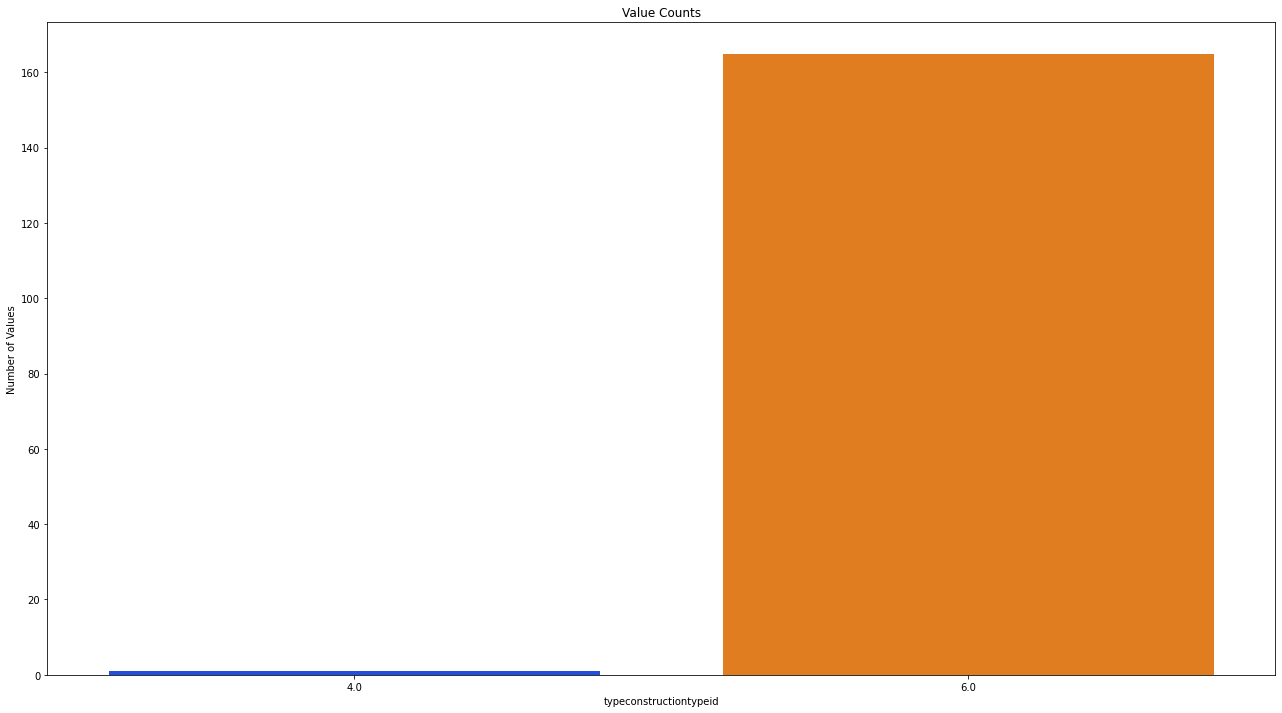

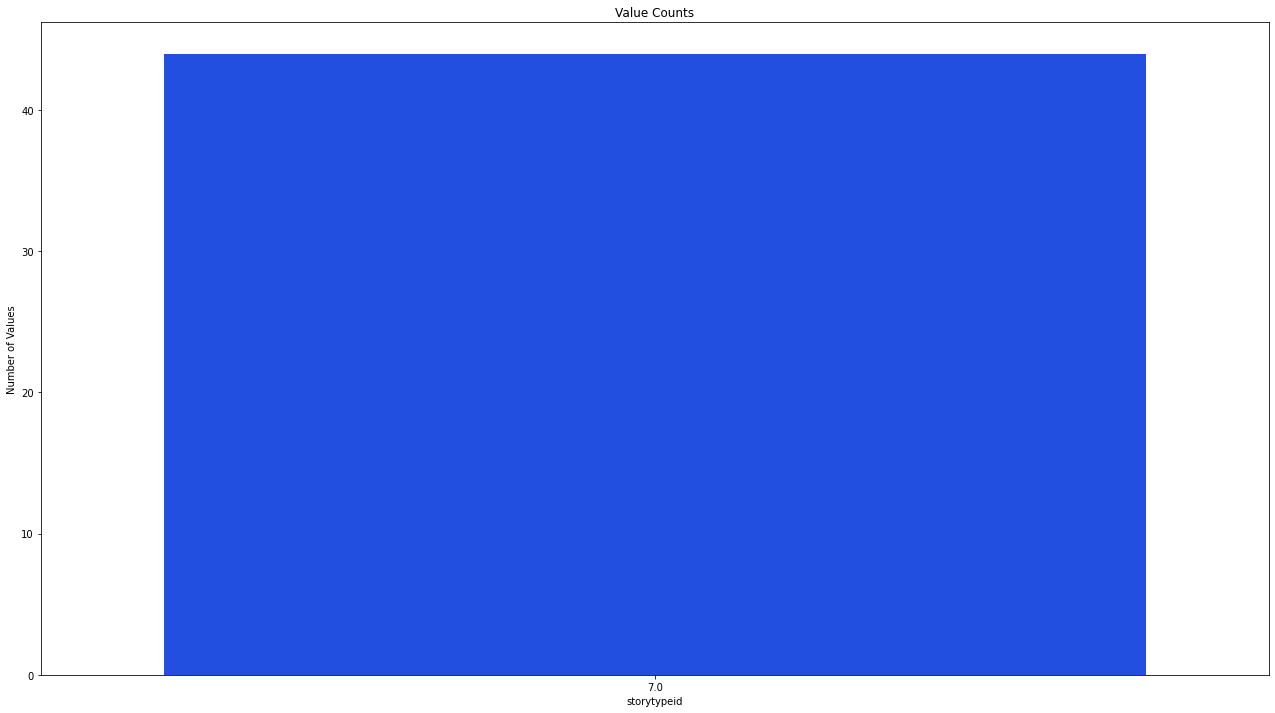

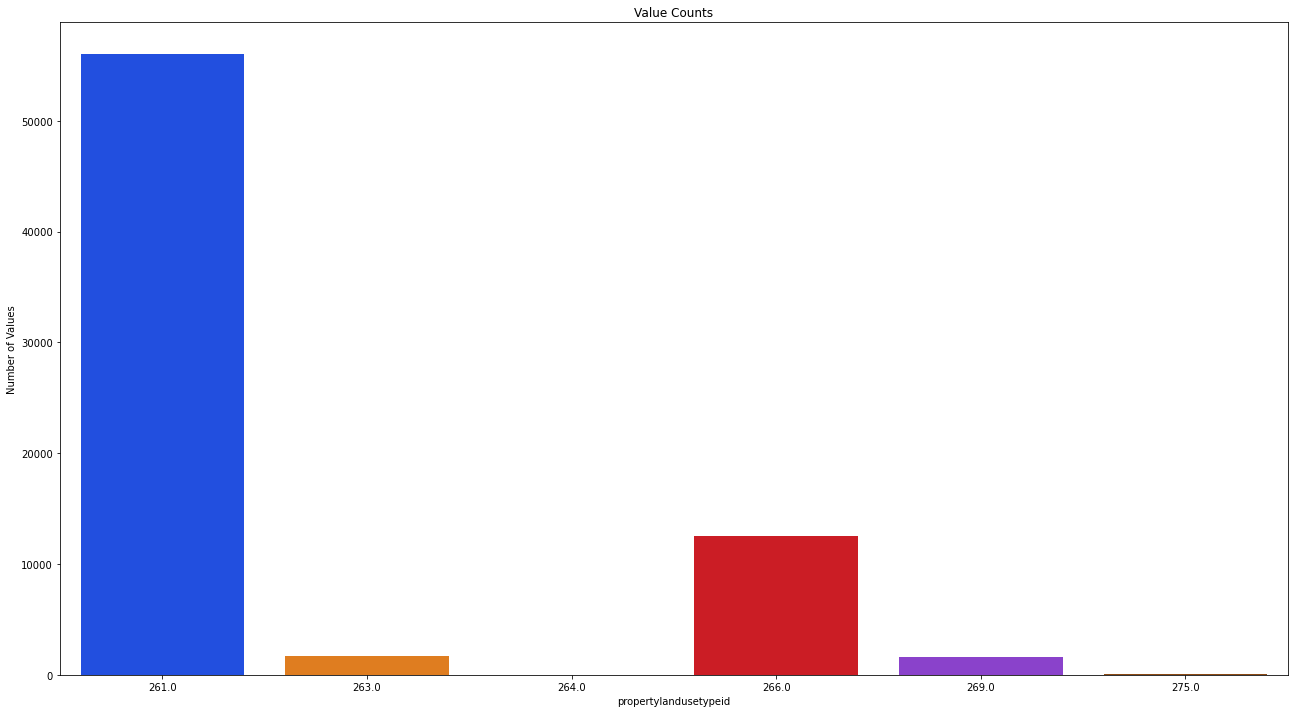

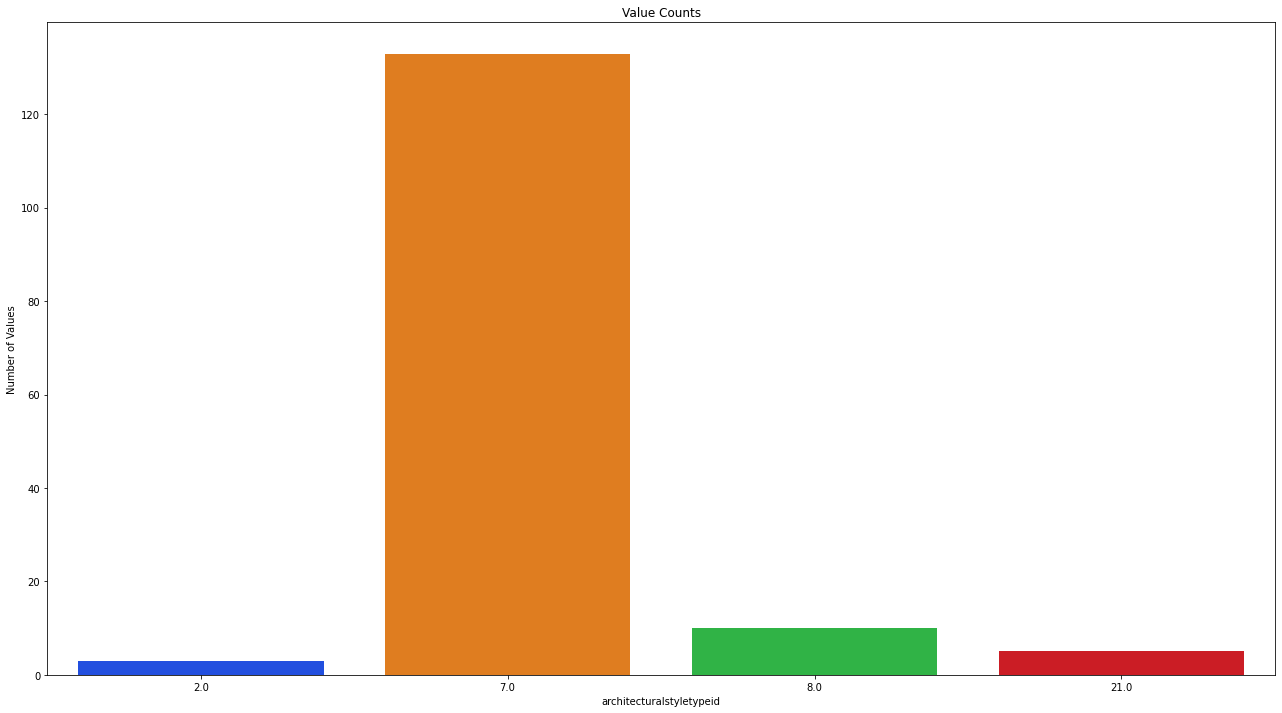

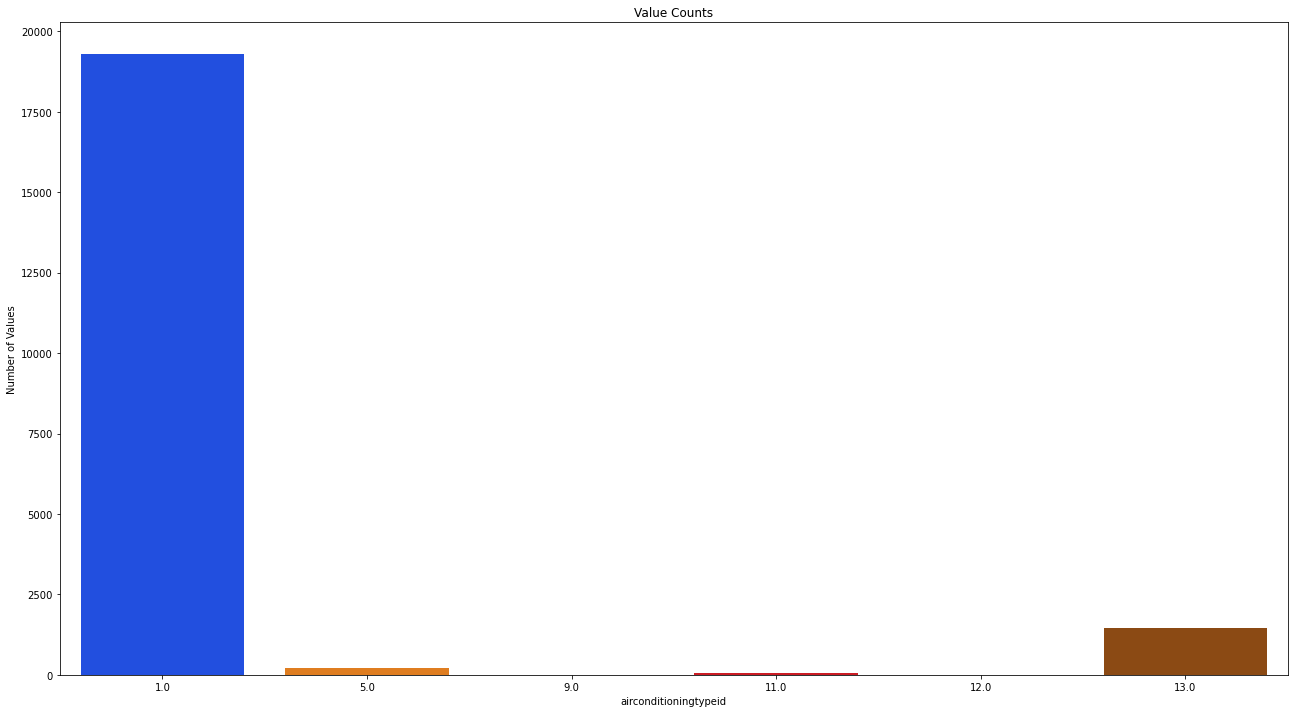

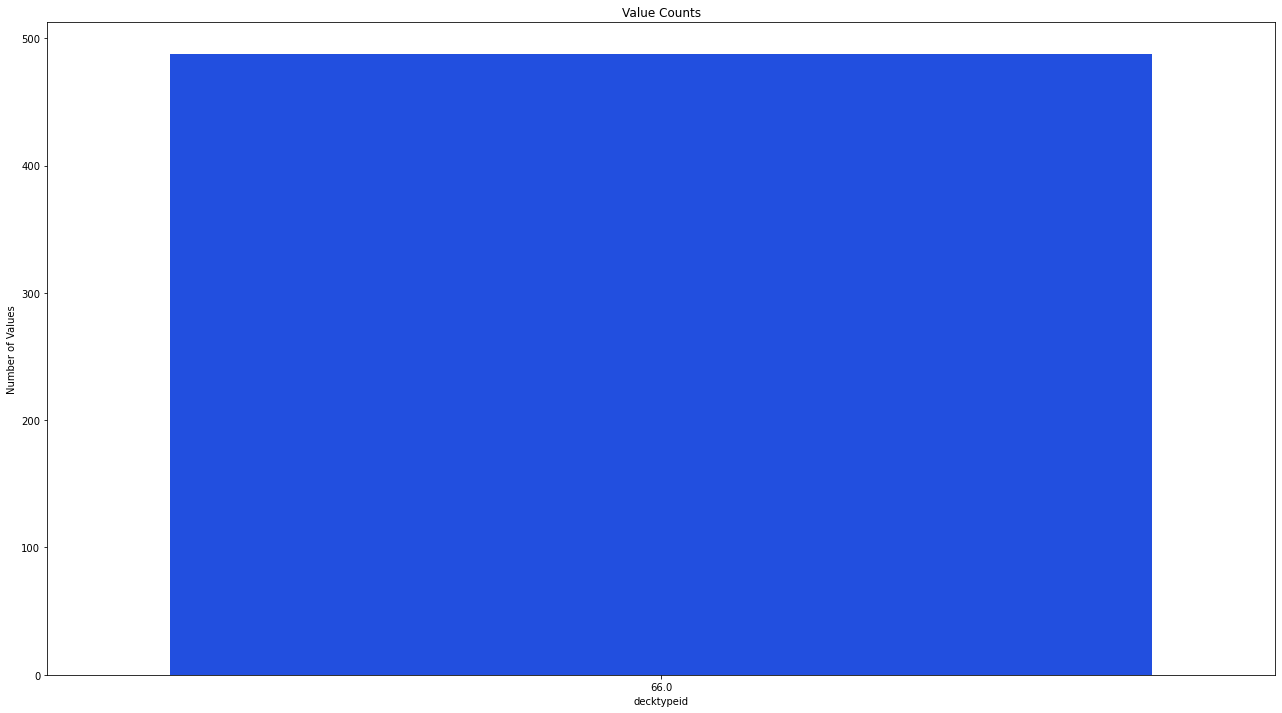

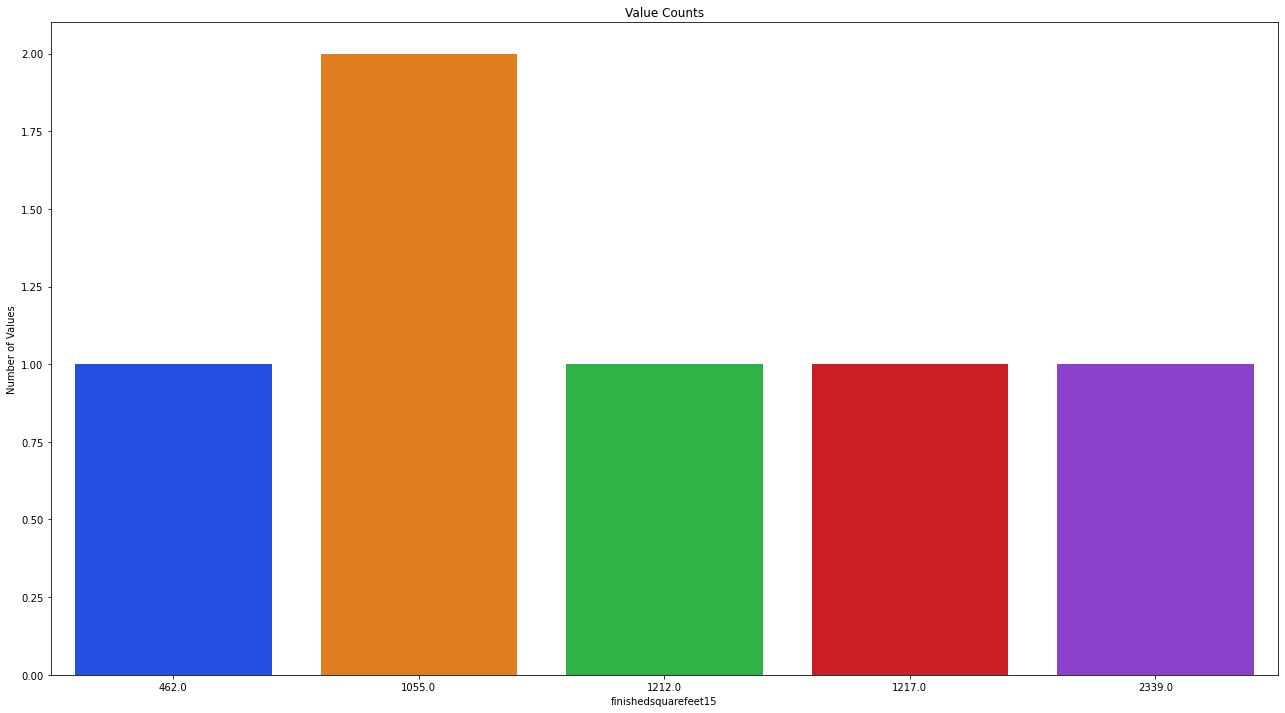

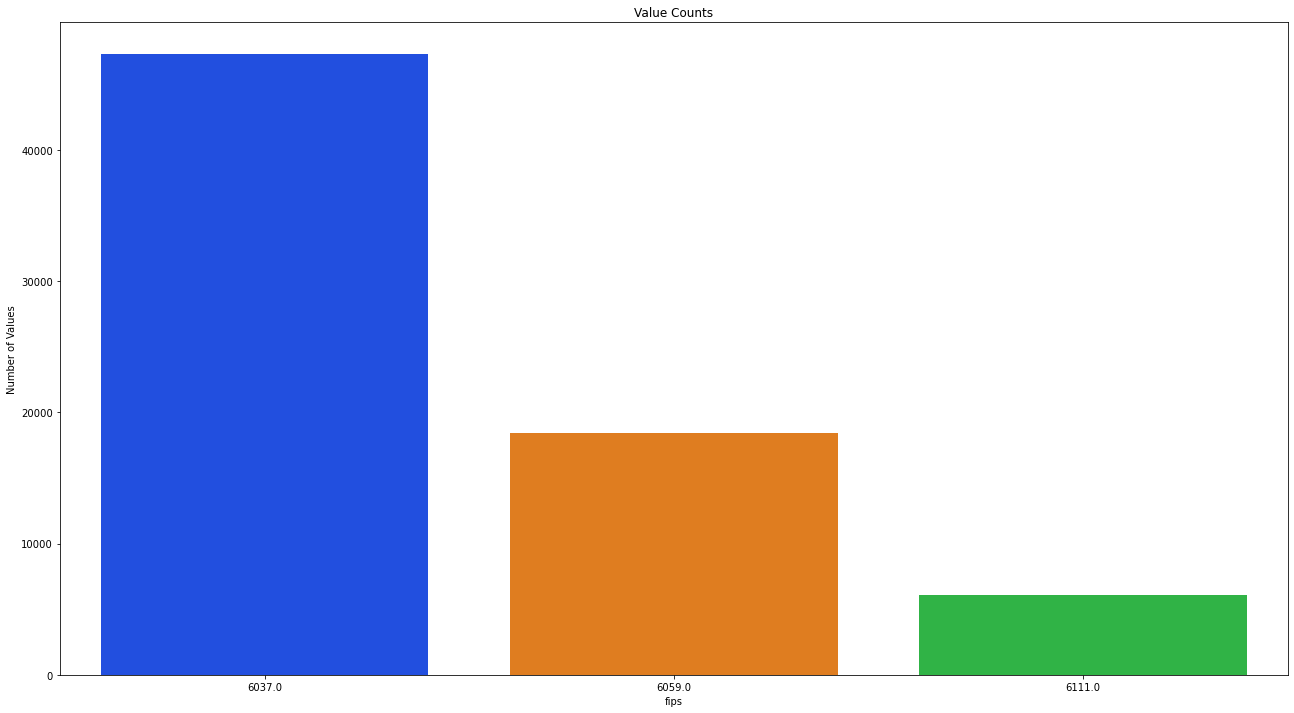

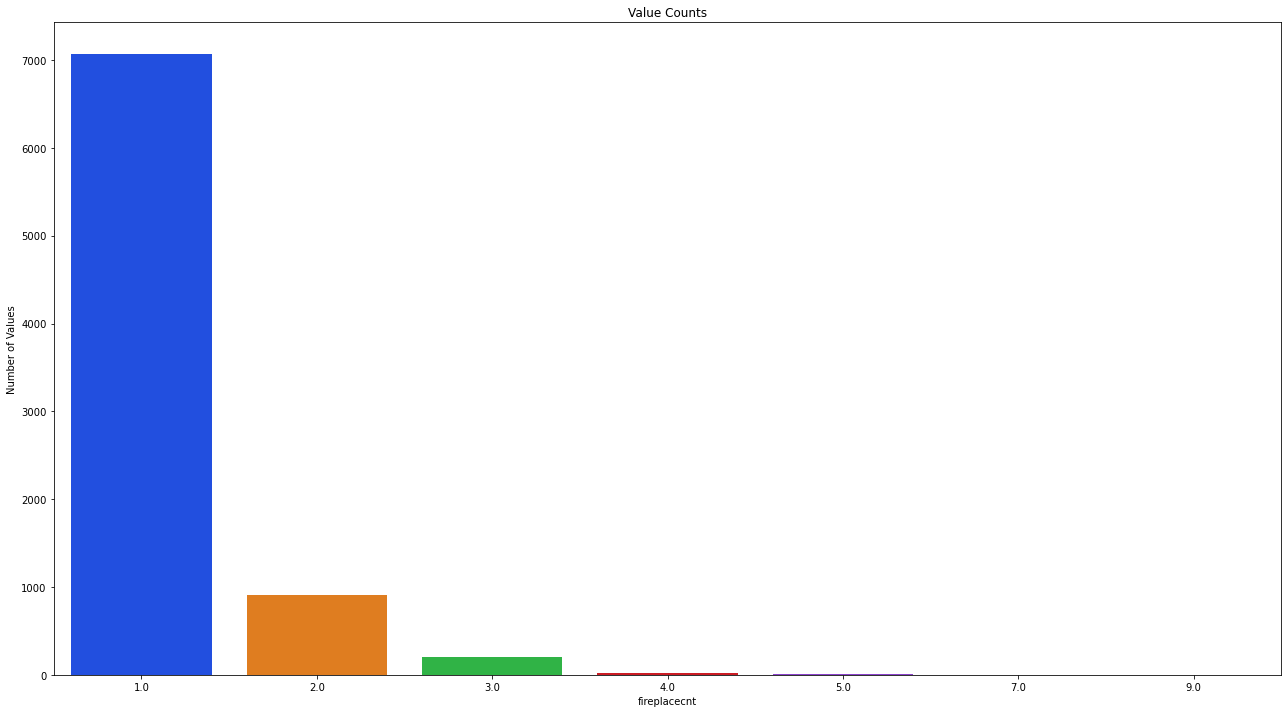

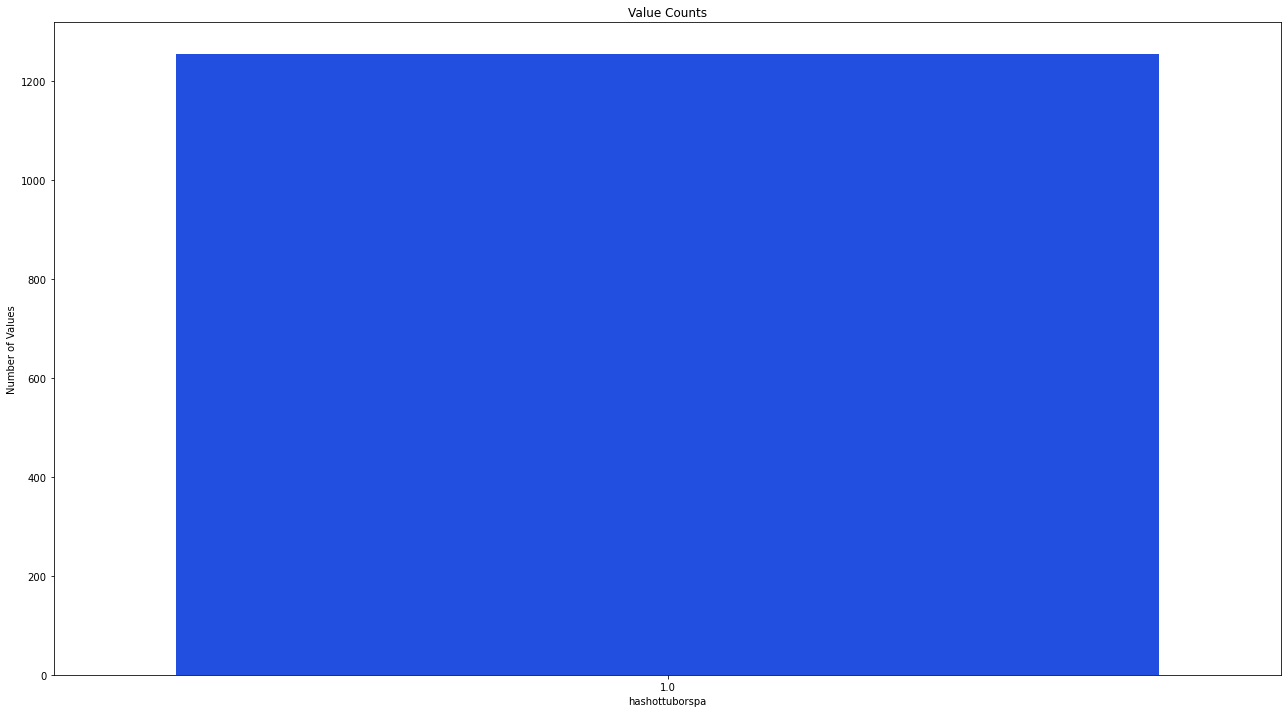

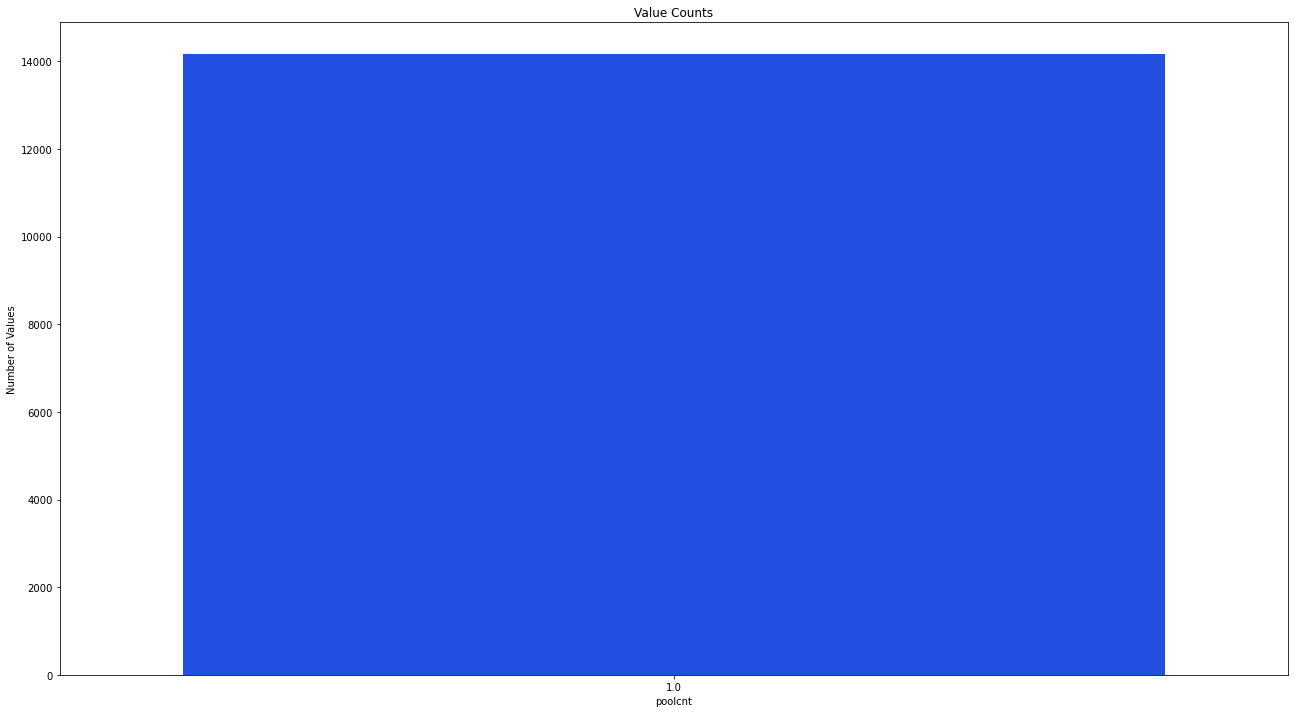

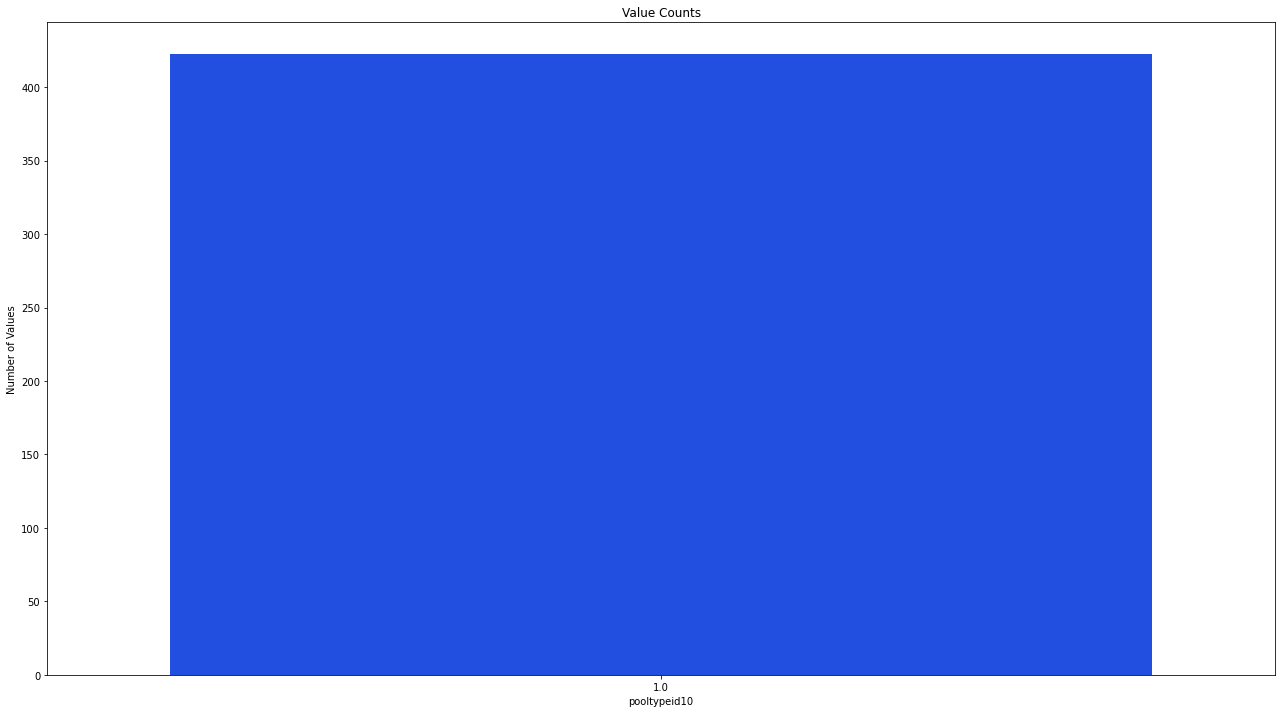

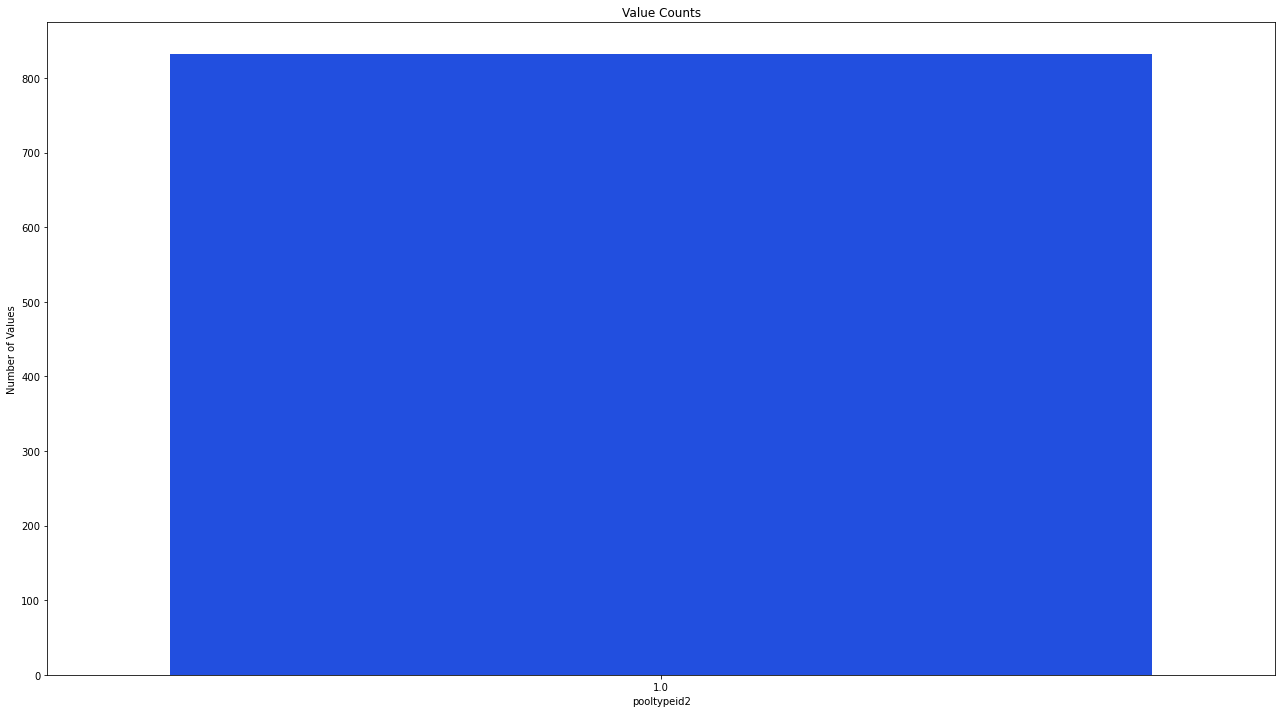

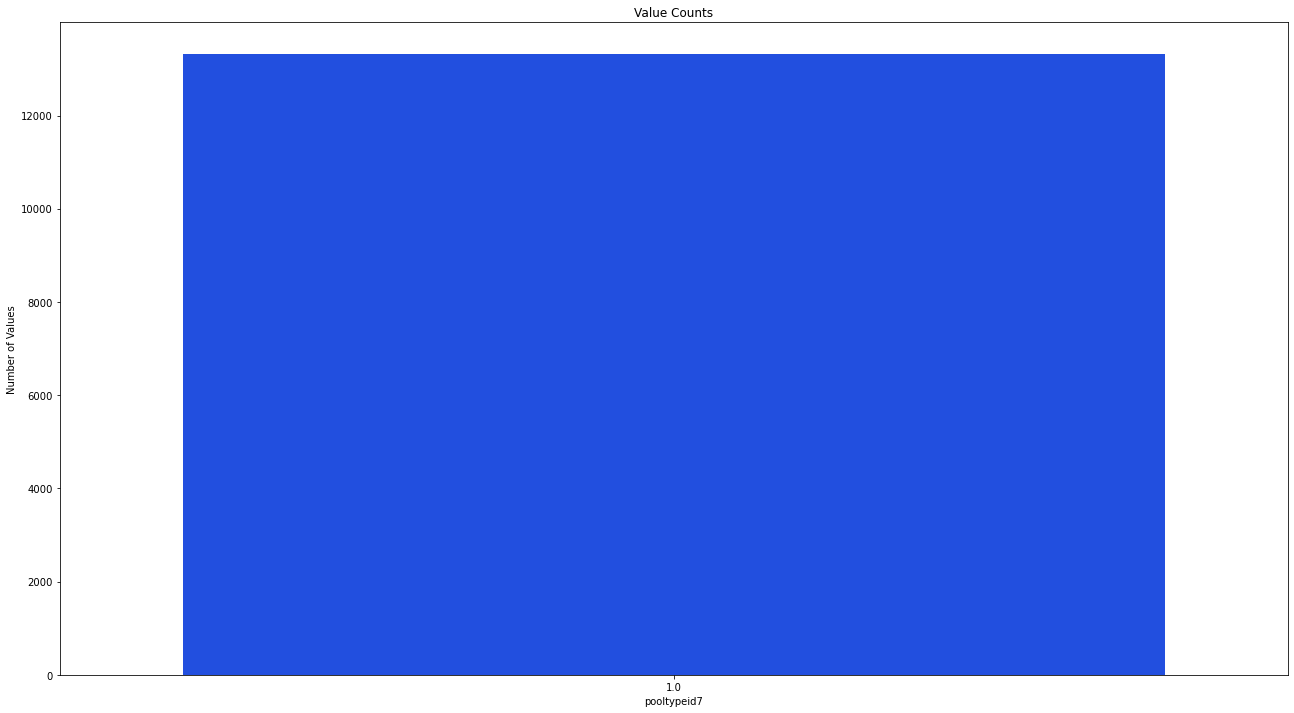

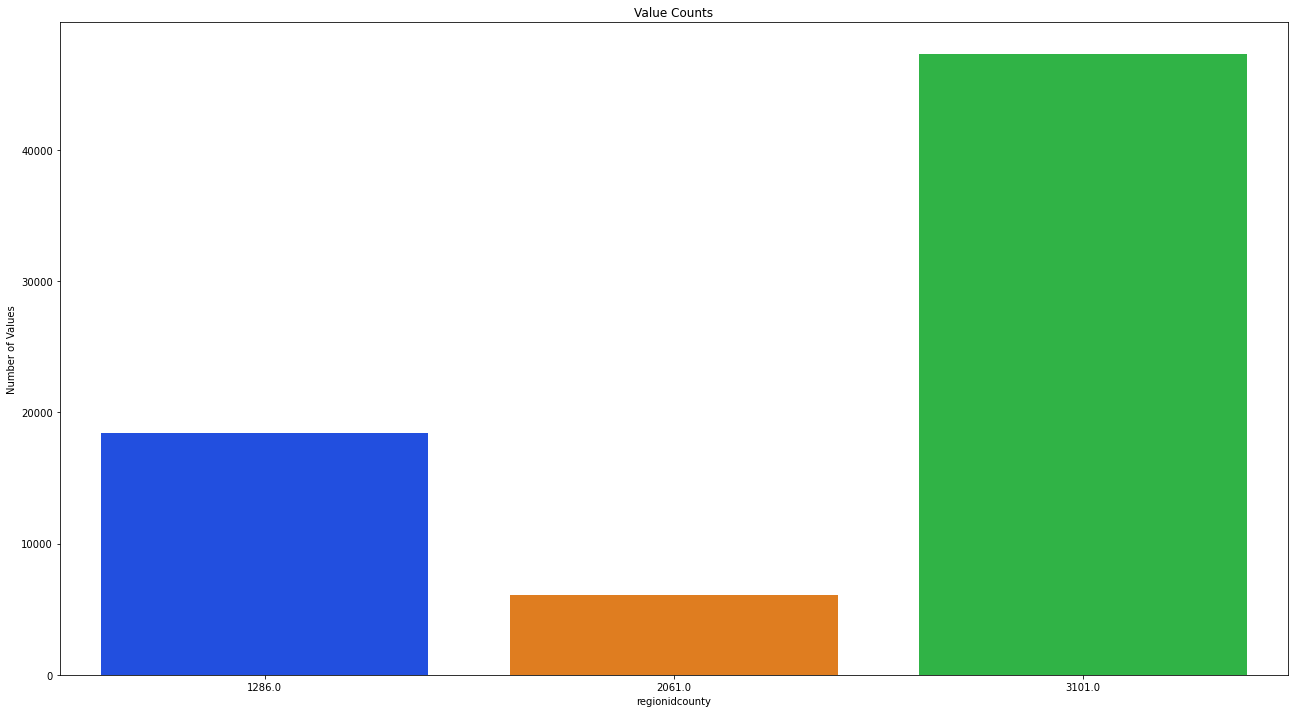

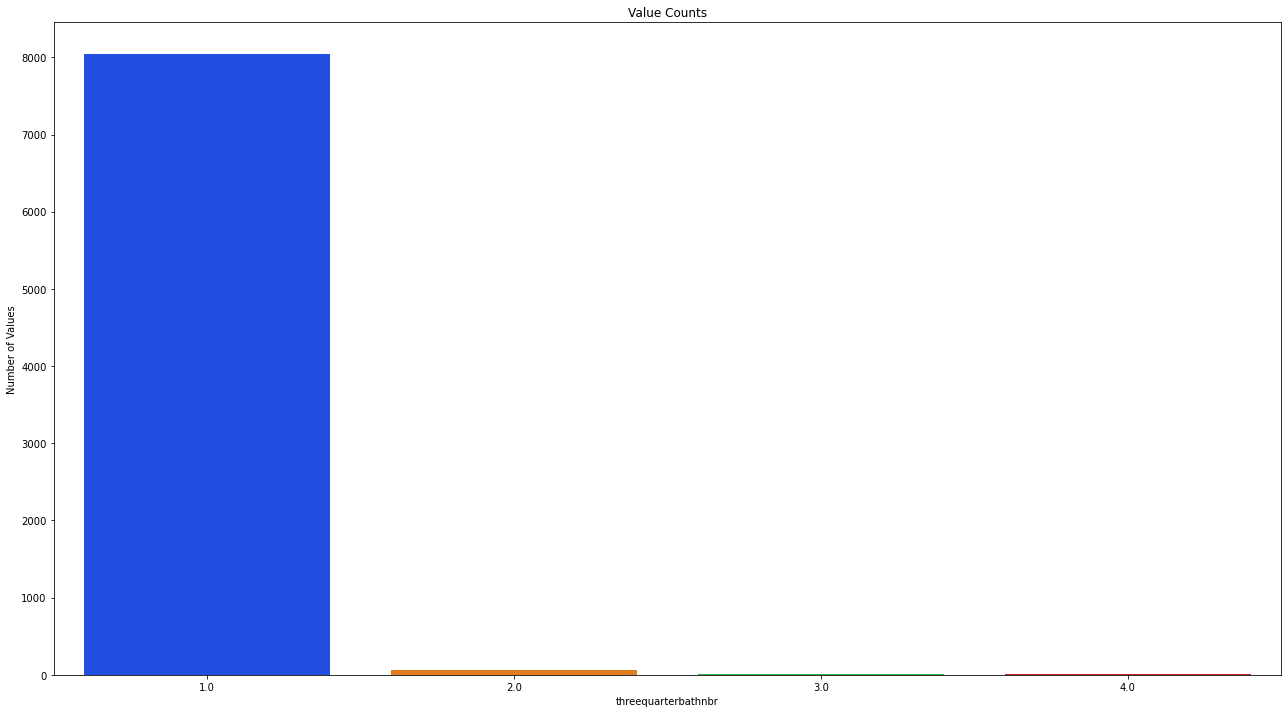

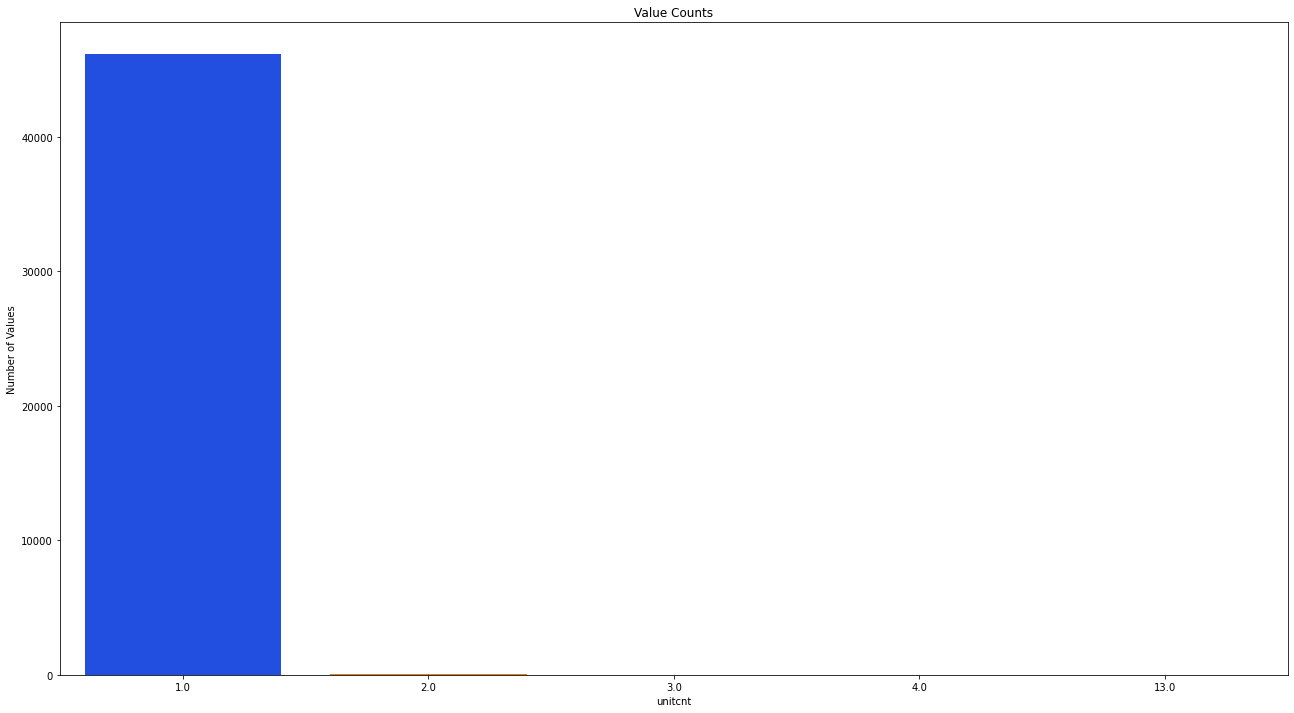

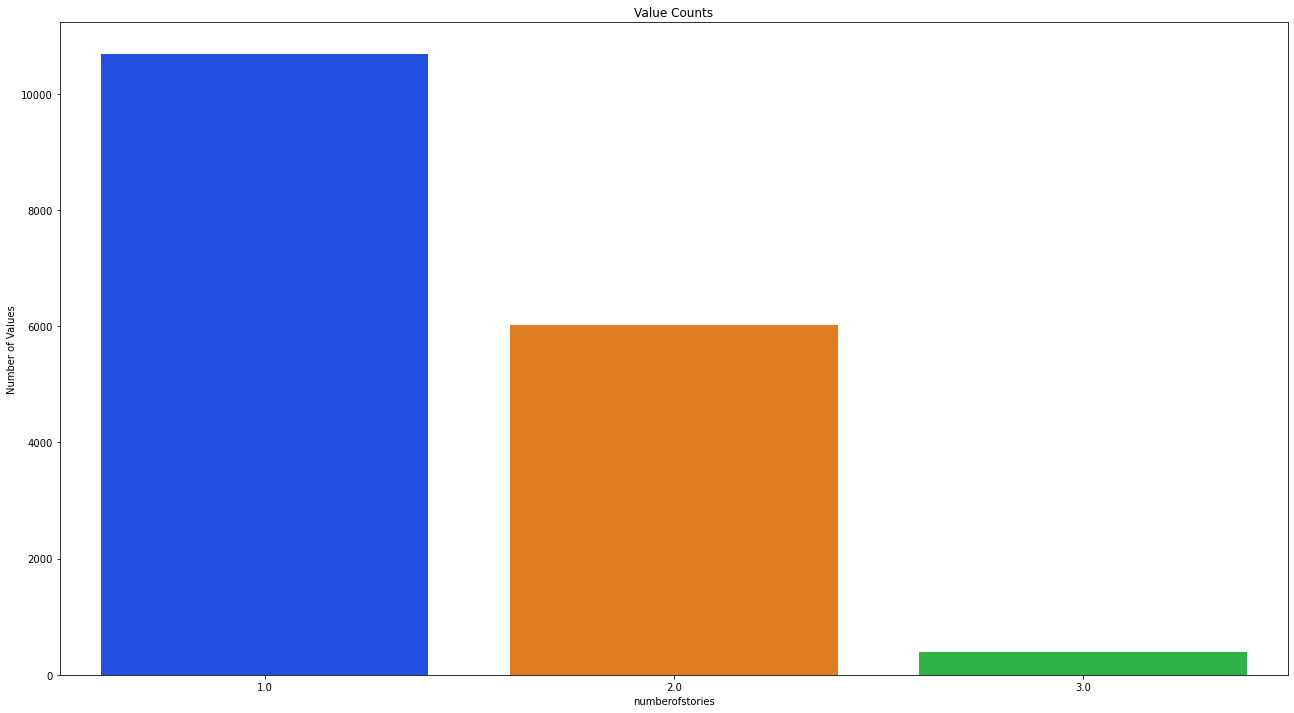

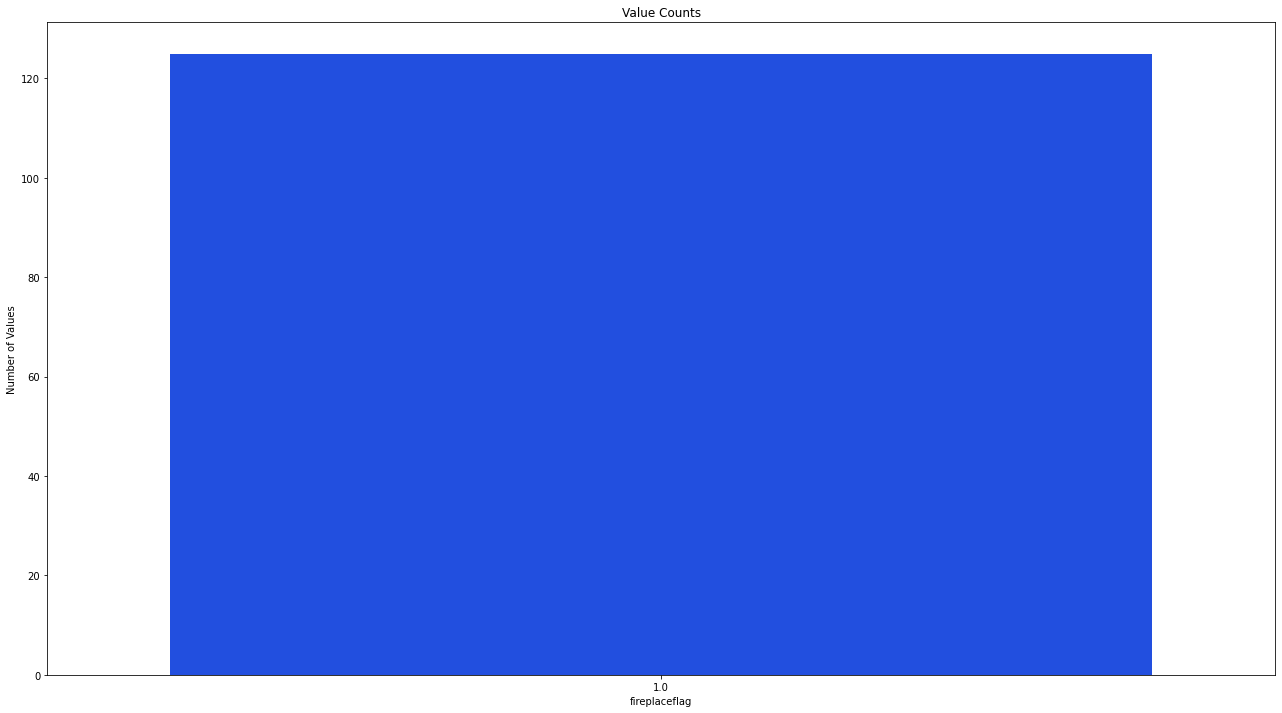

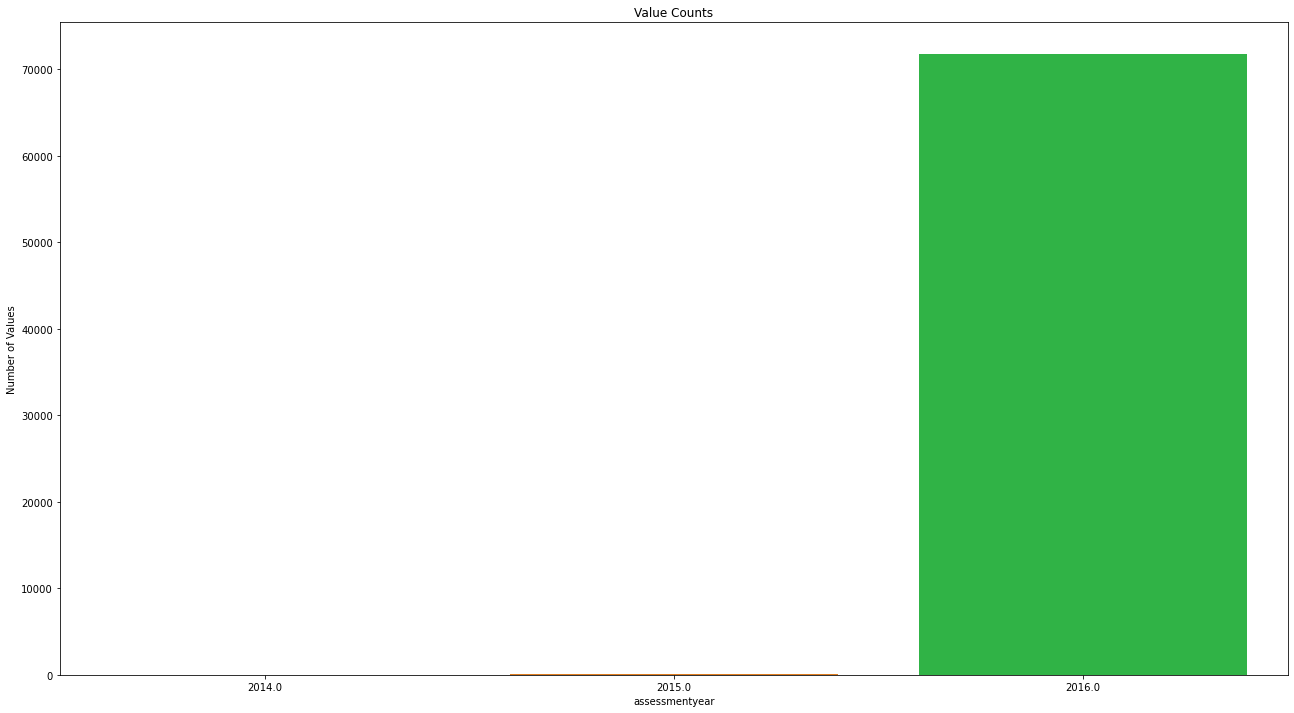

In [10]:
numeric_values_low_value_count(df)

<AxesSubplot:title={'center':'Distribution'}, xlabel='logerror', ylabel='Number of Values'>

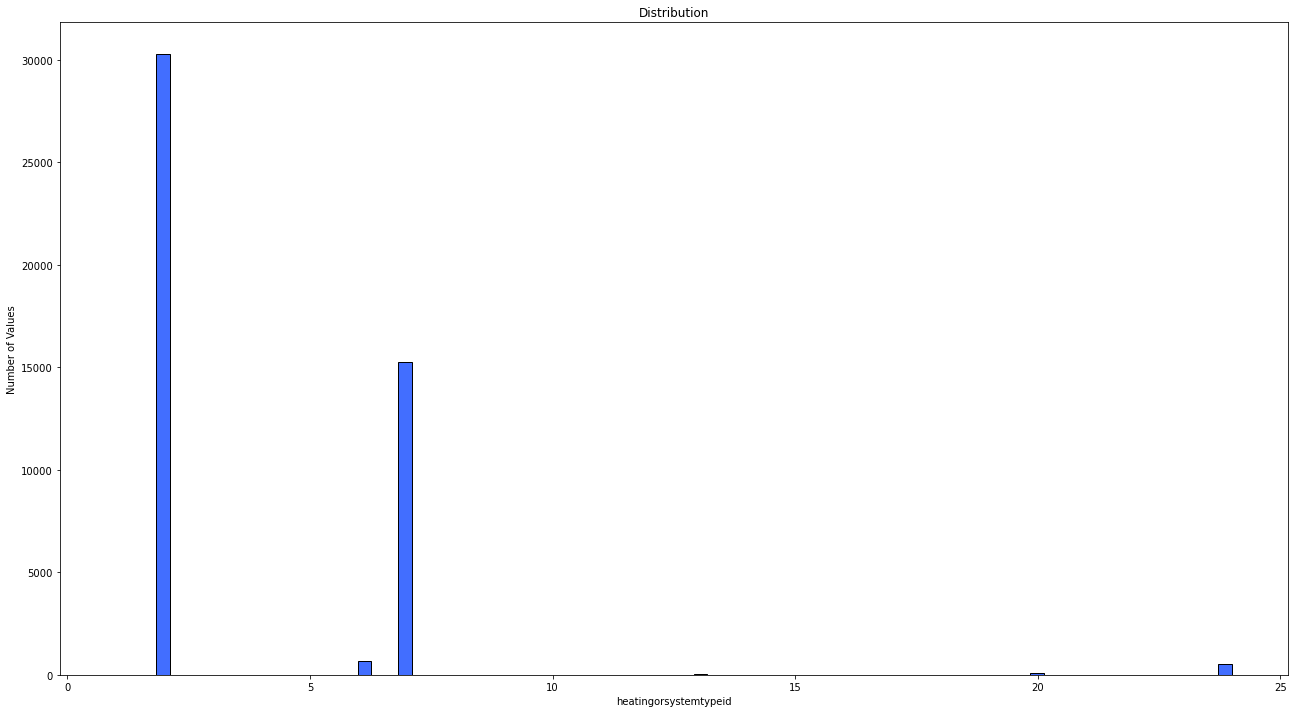

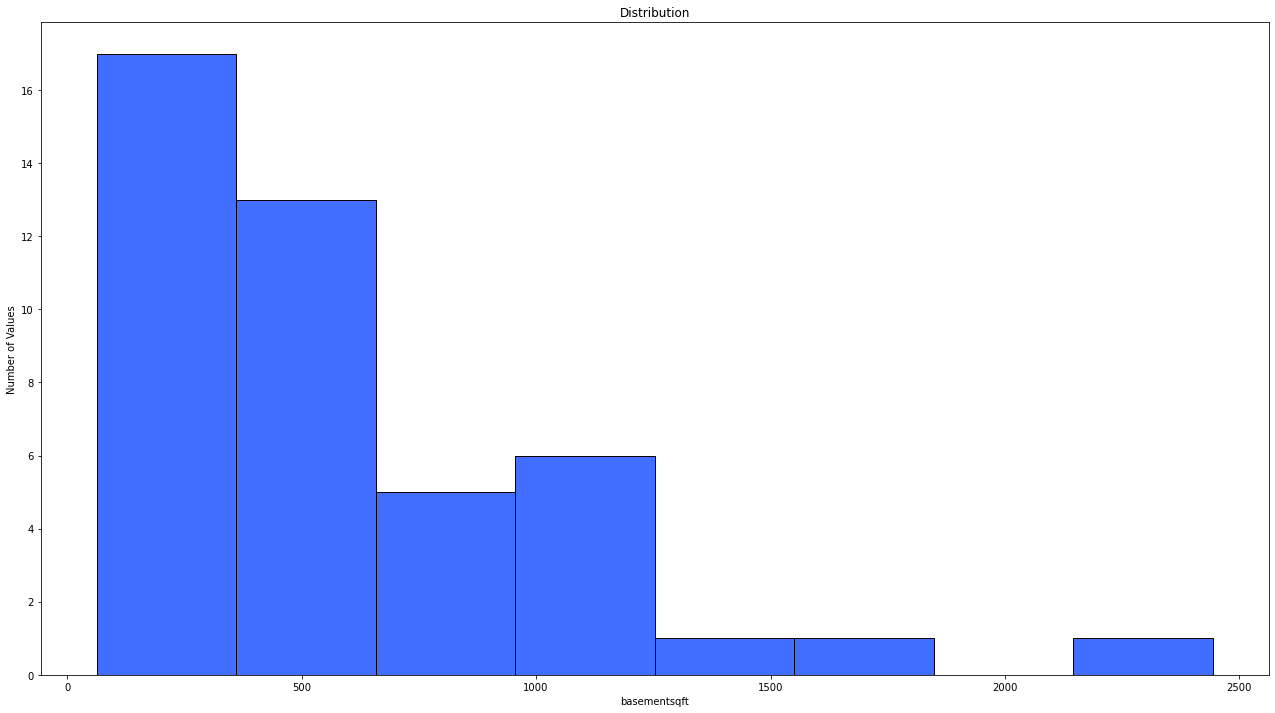

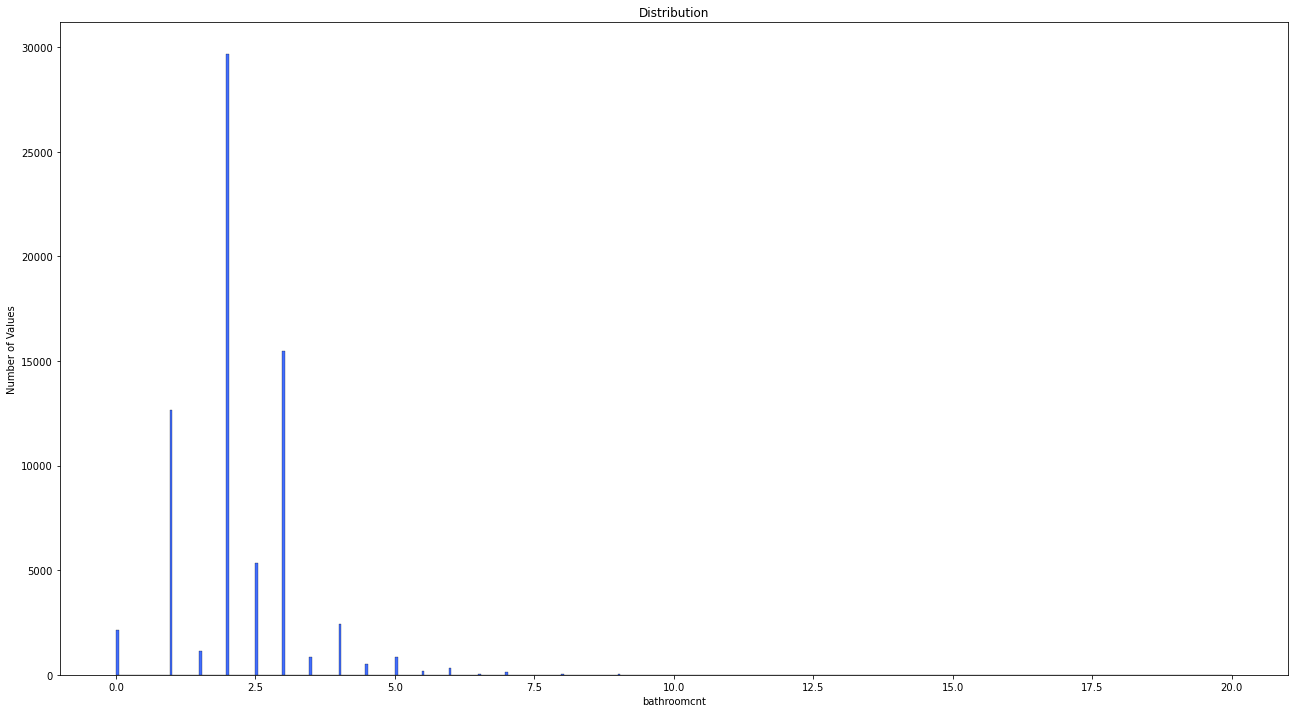

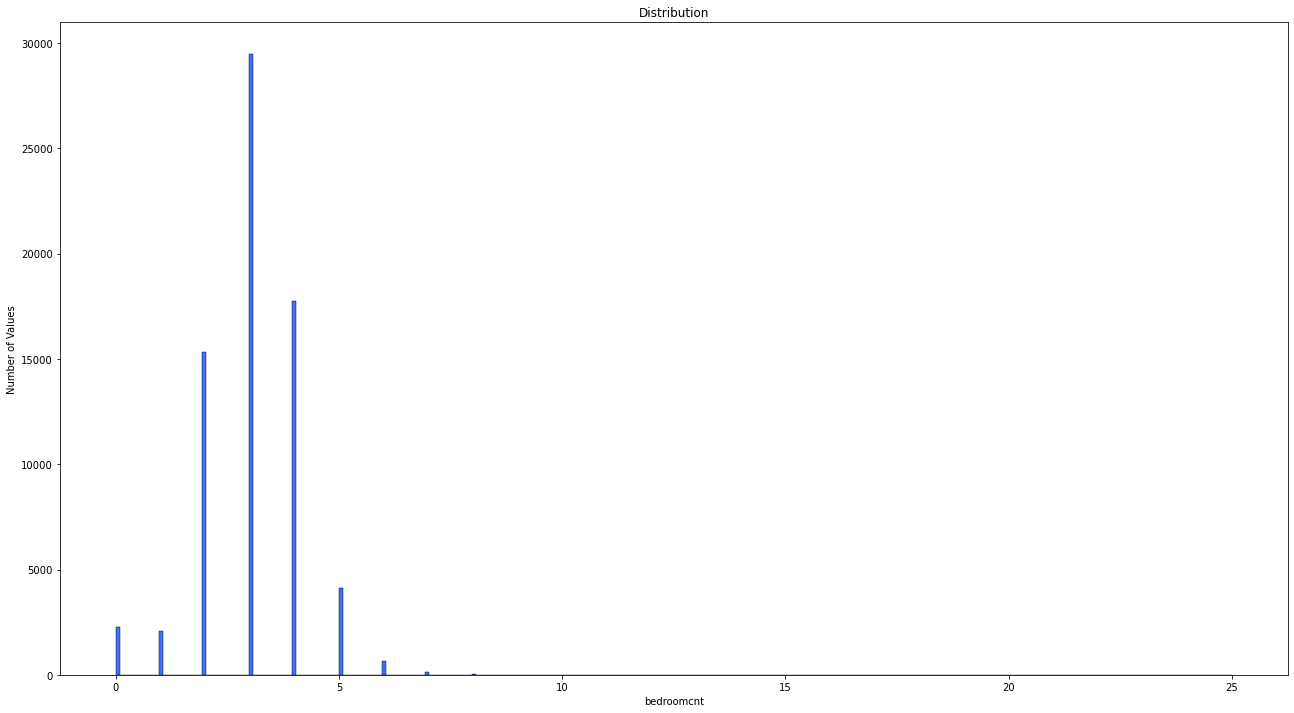

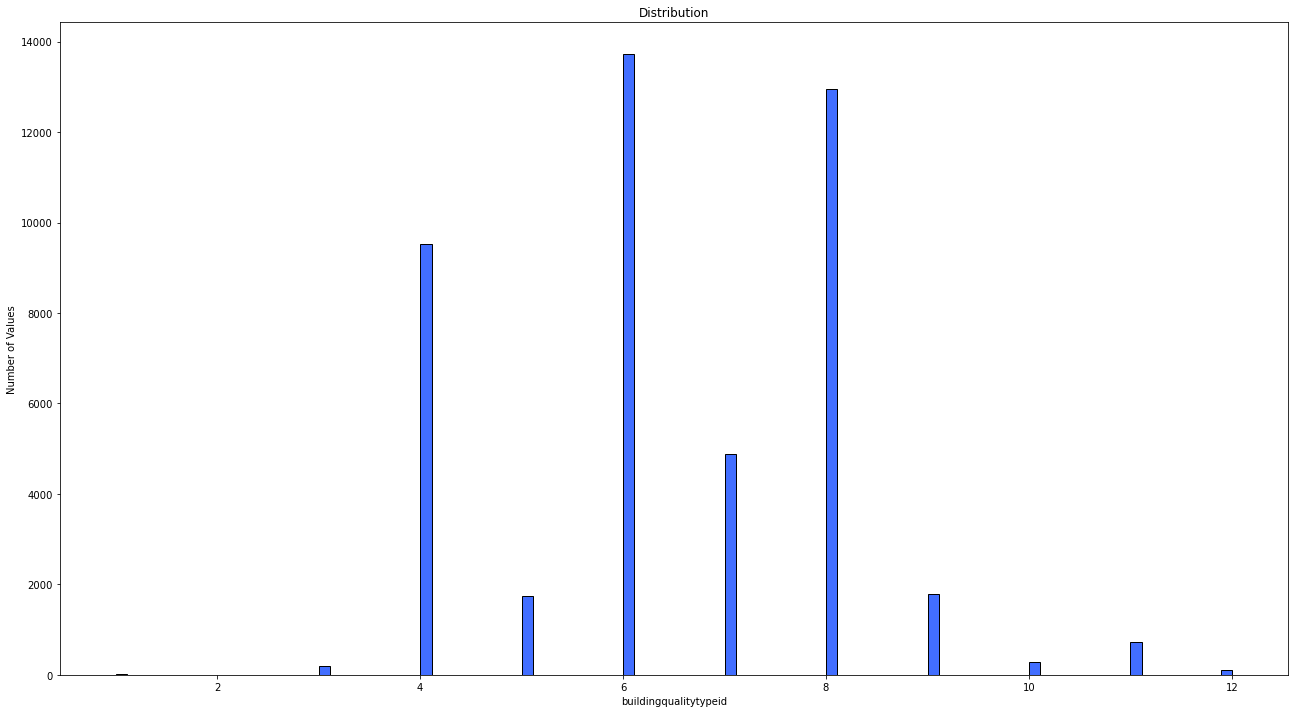

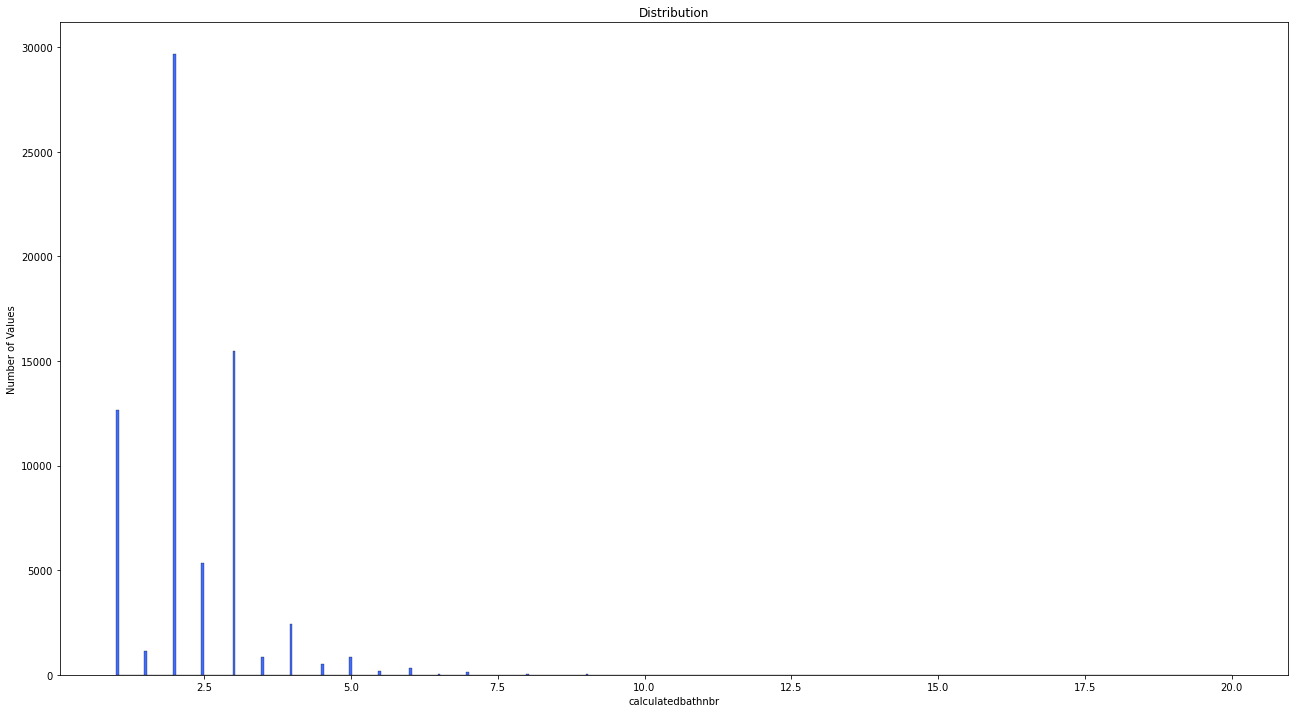

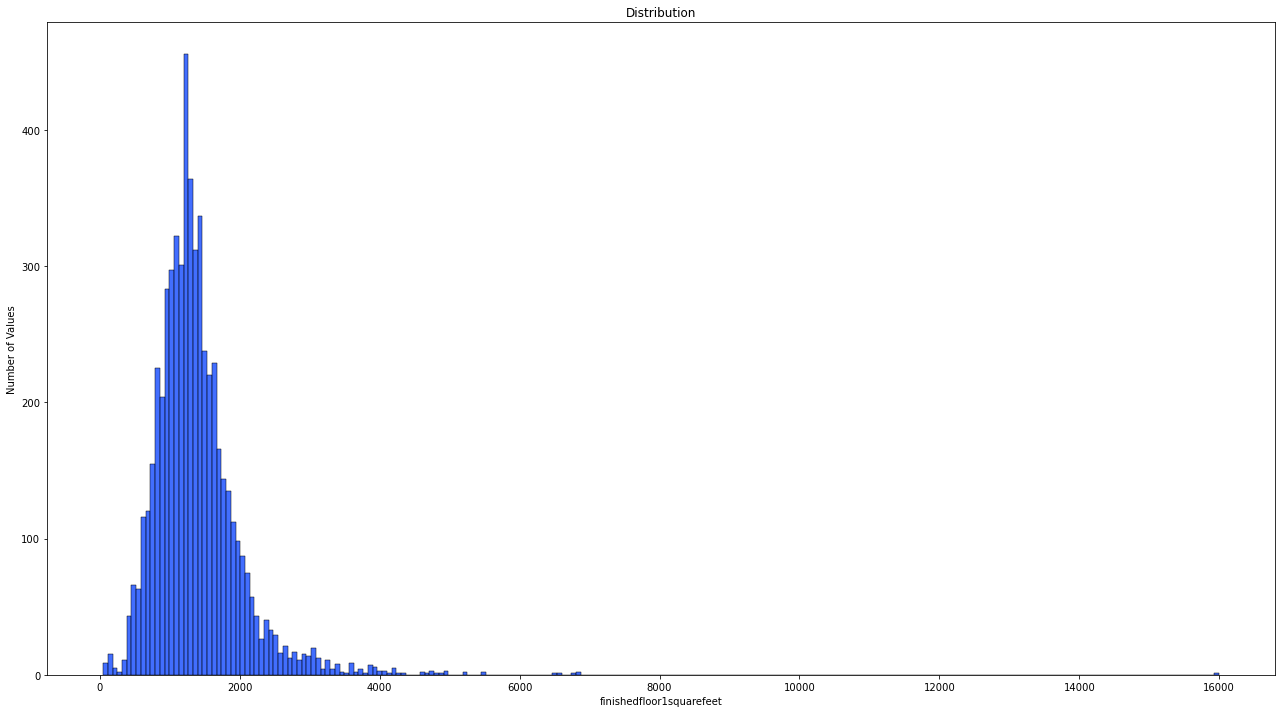

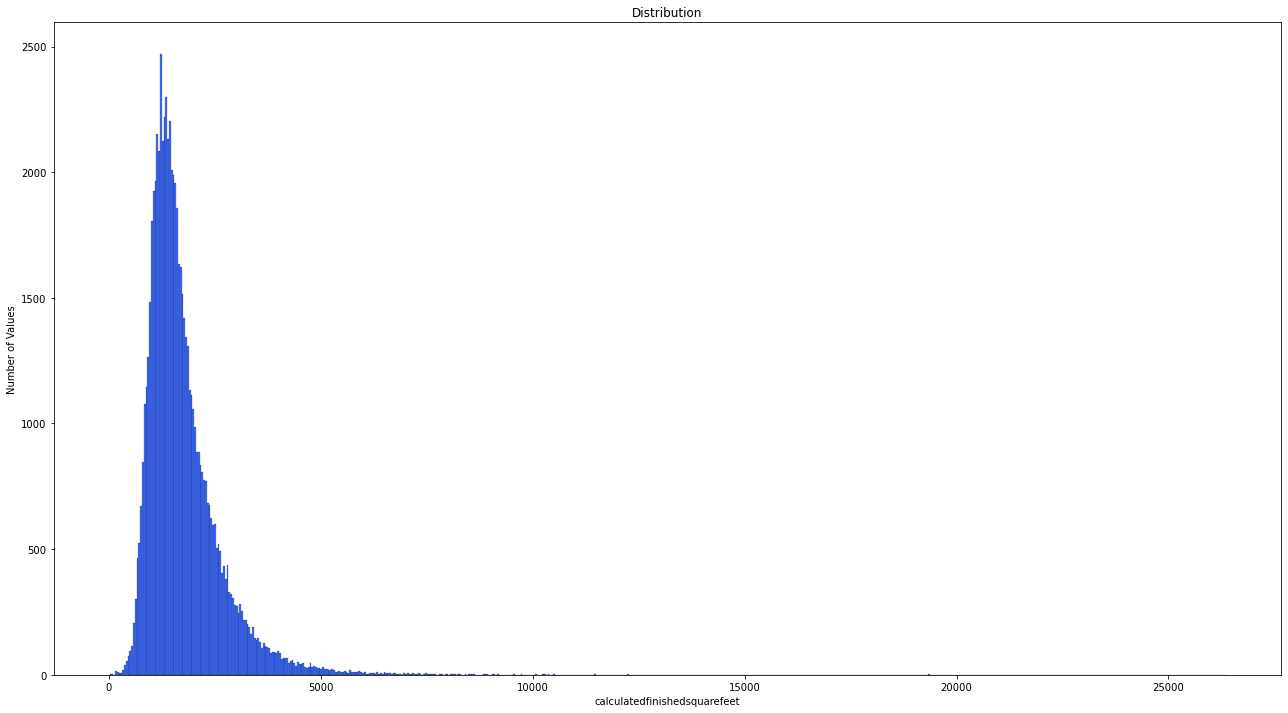

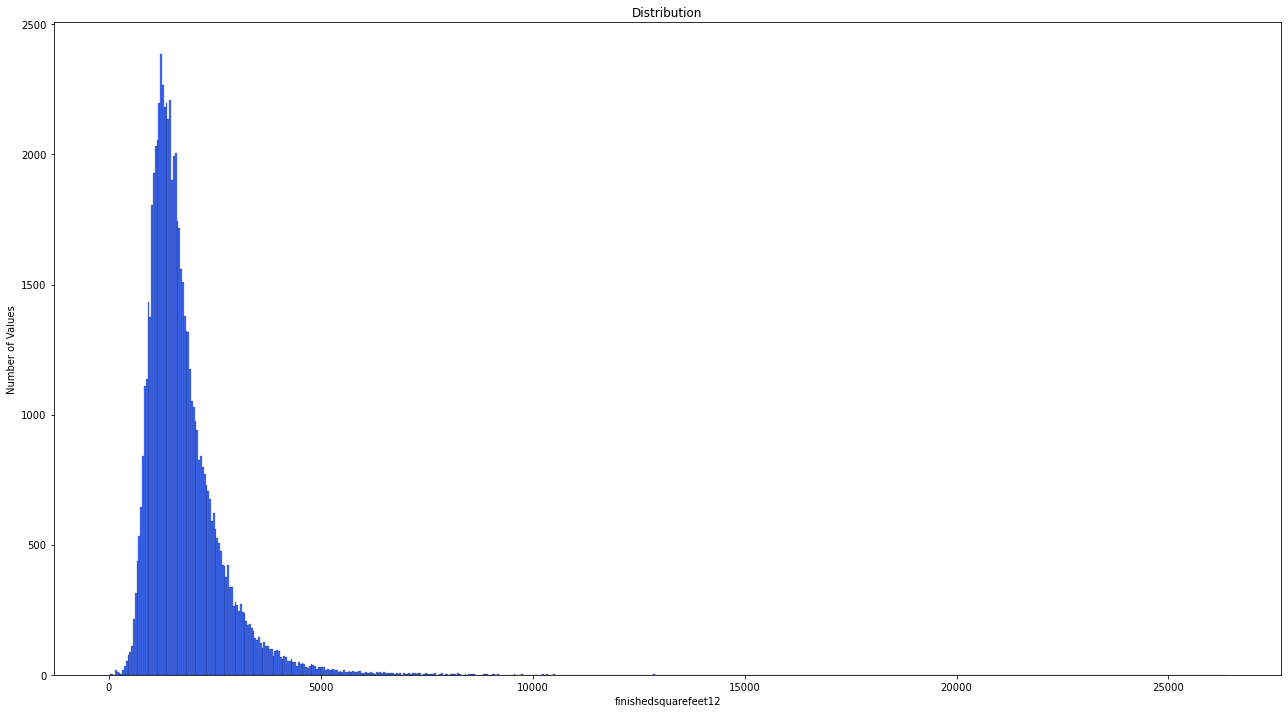

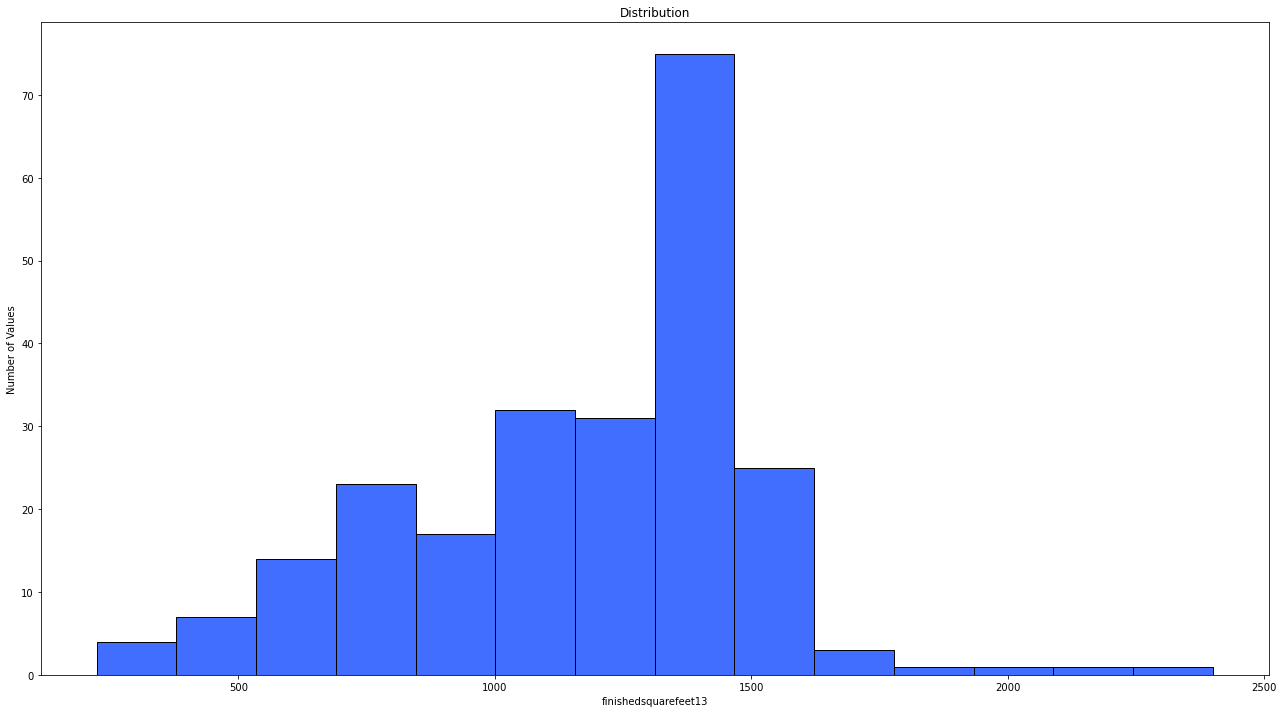

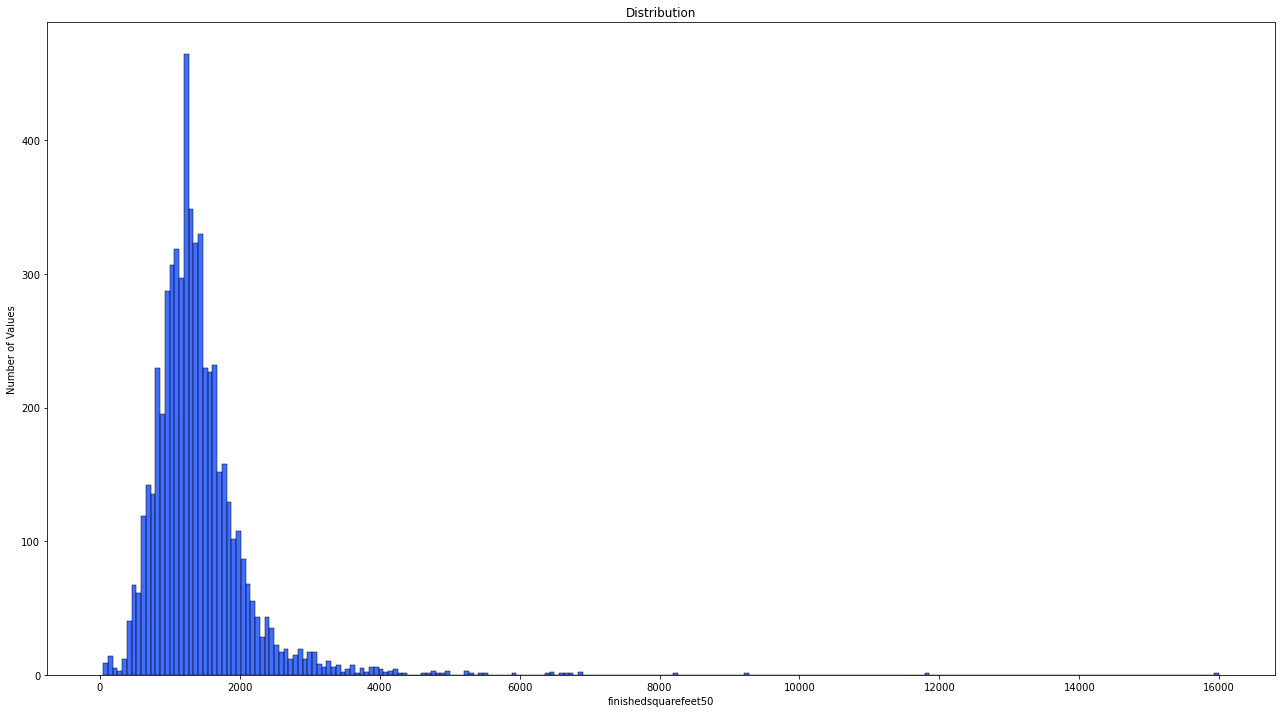

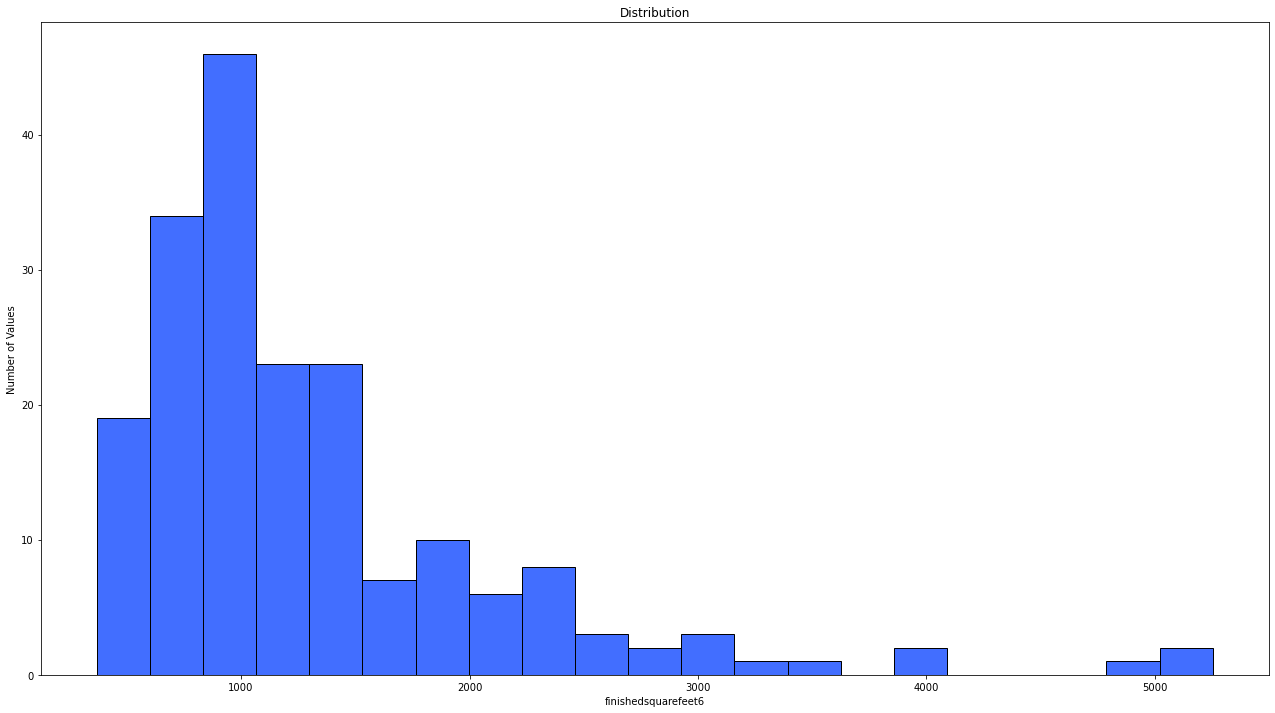

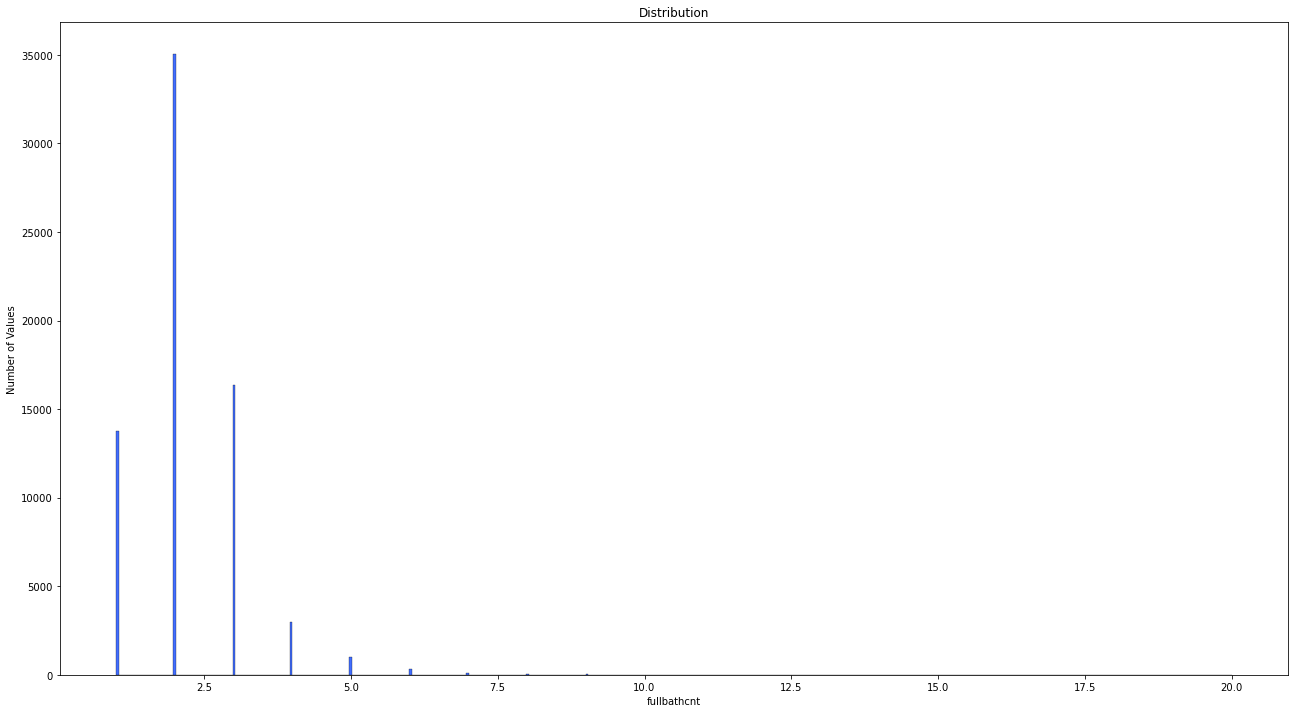

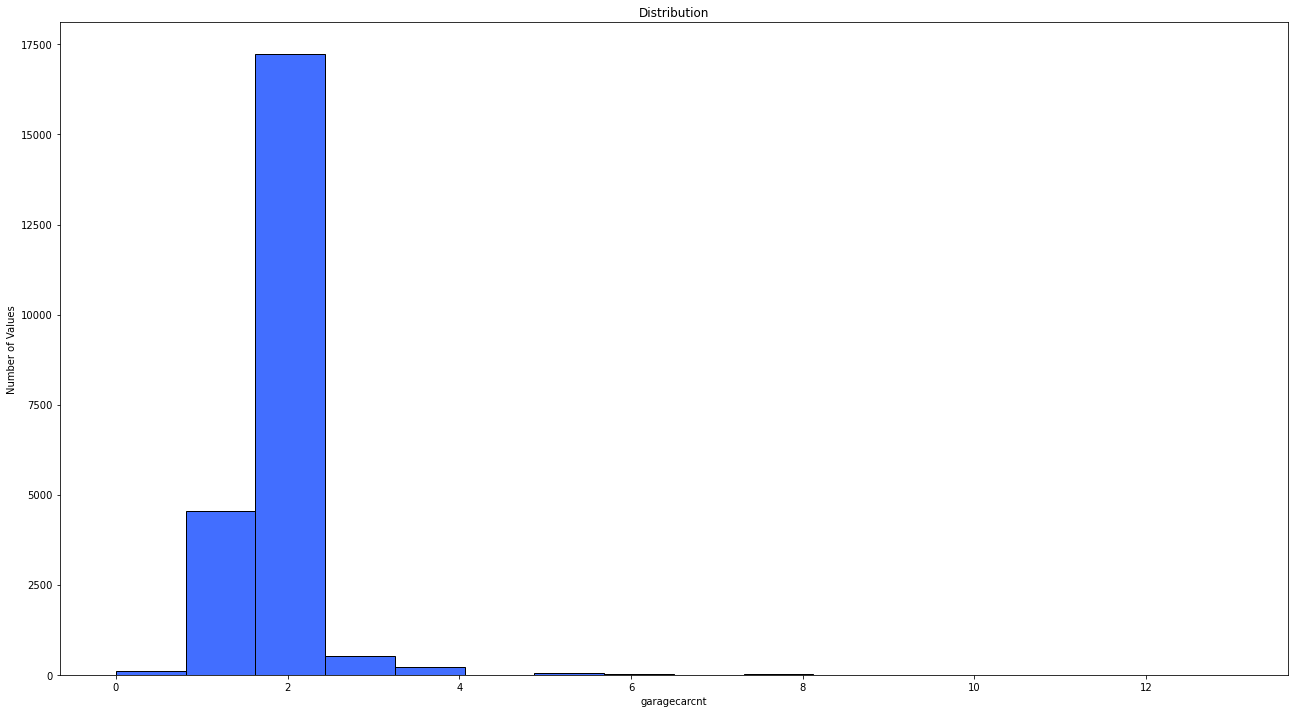

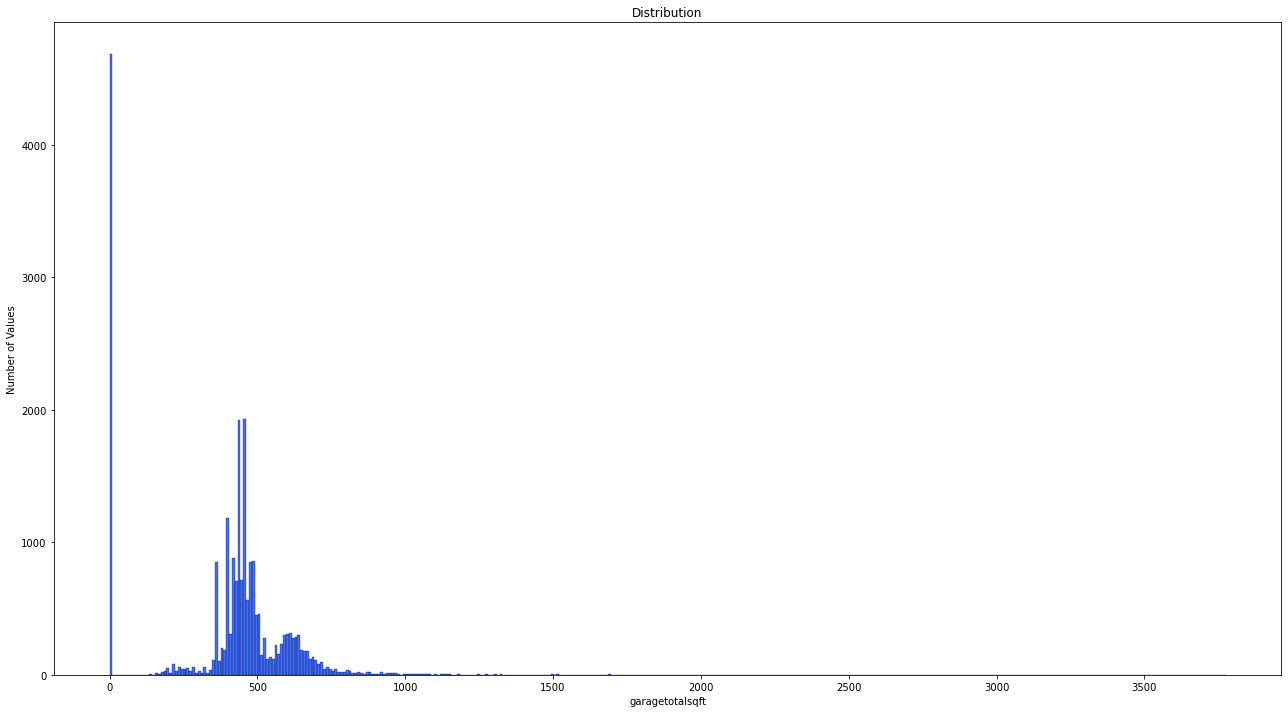

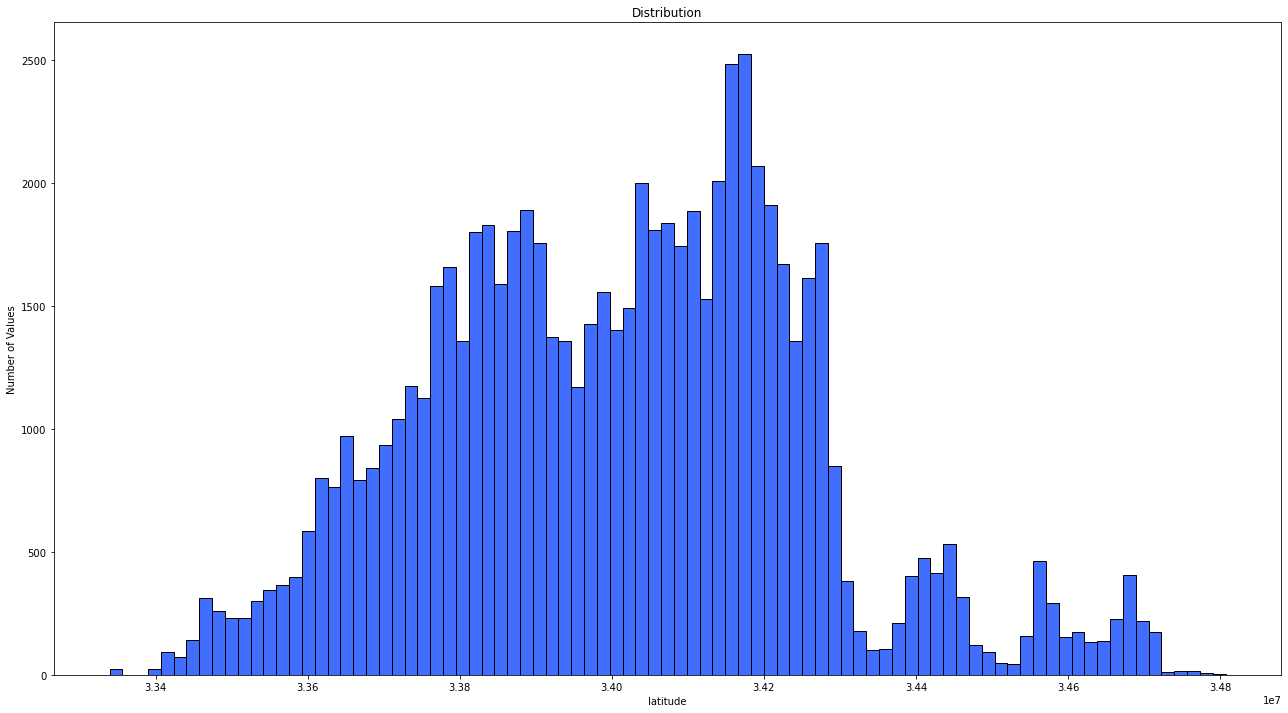

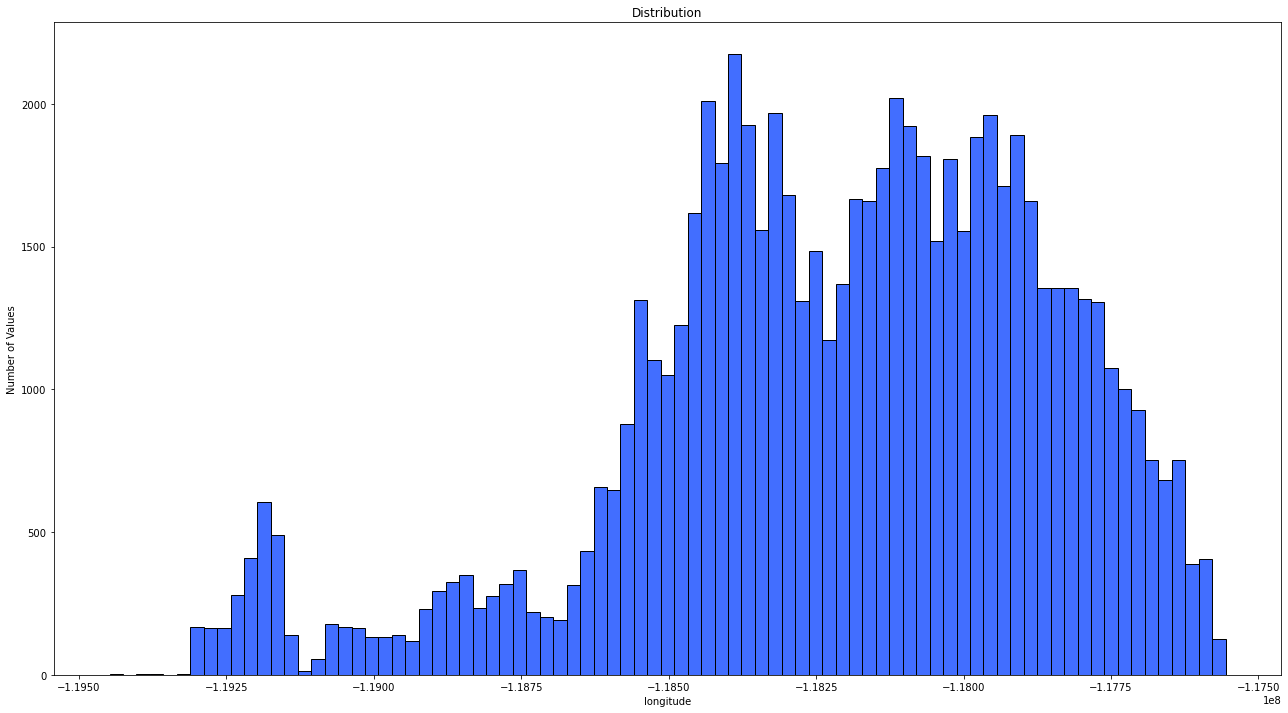

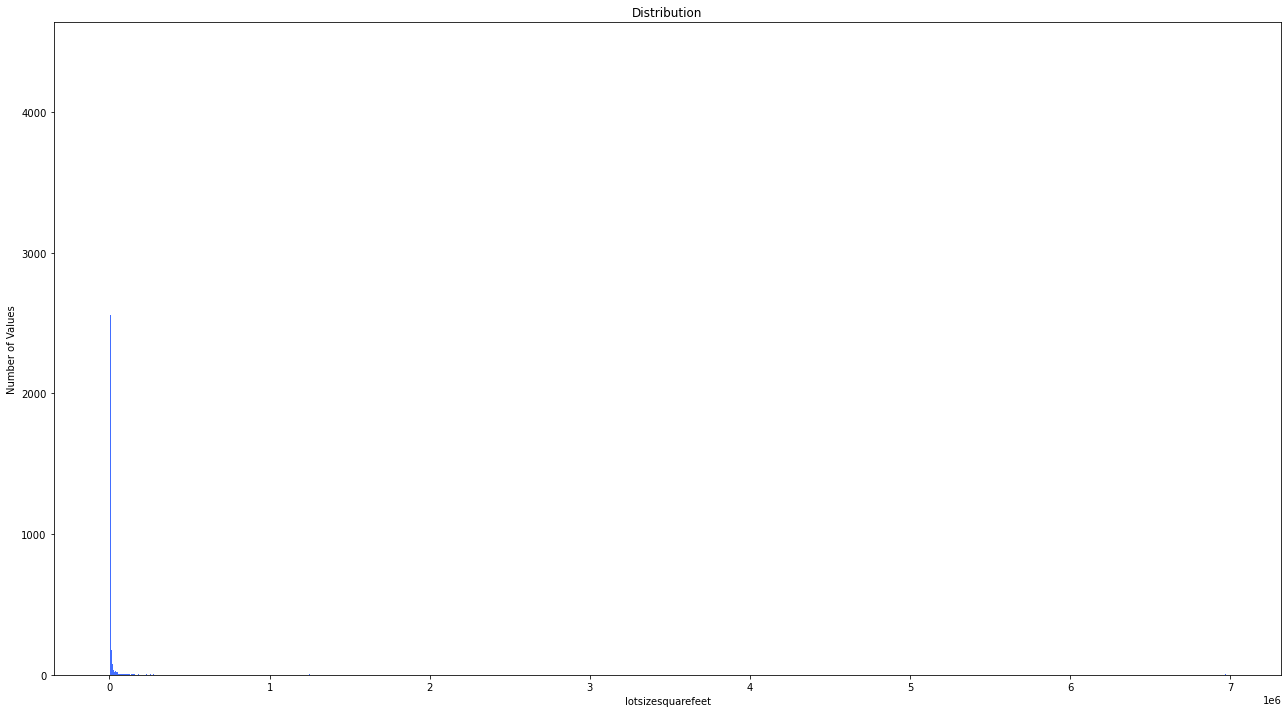

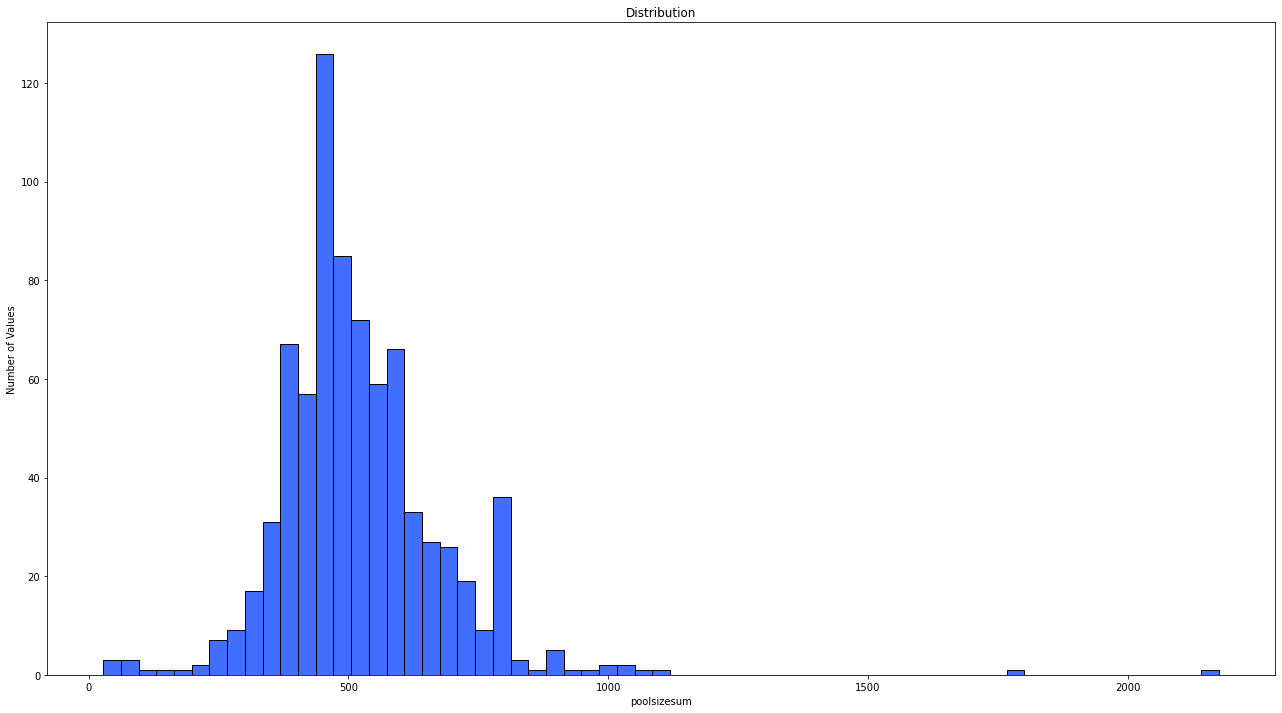

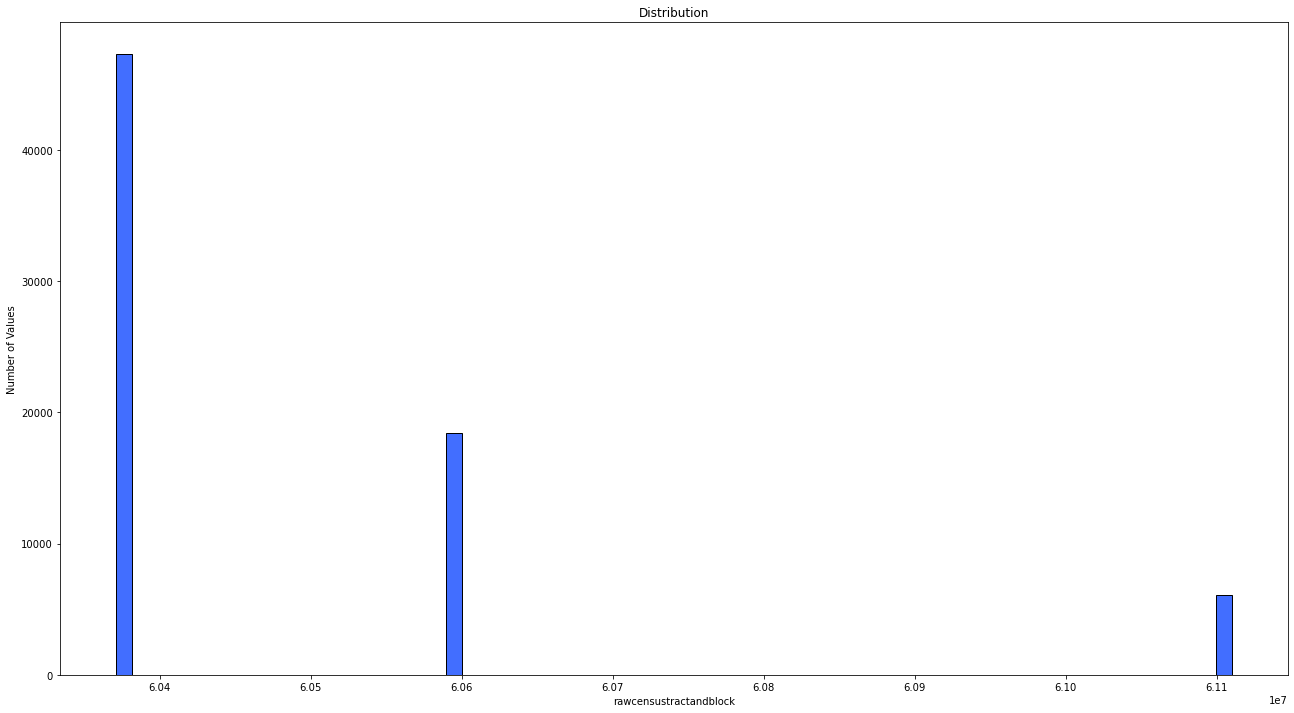

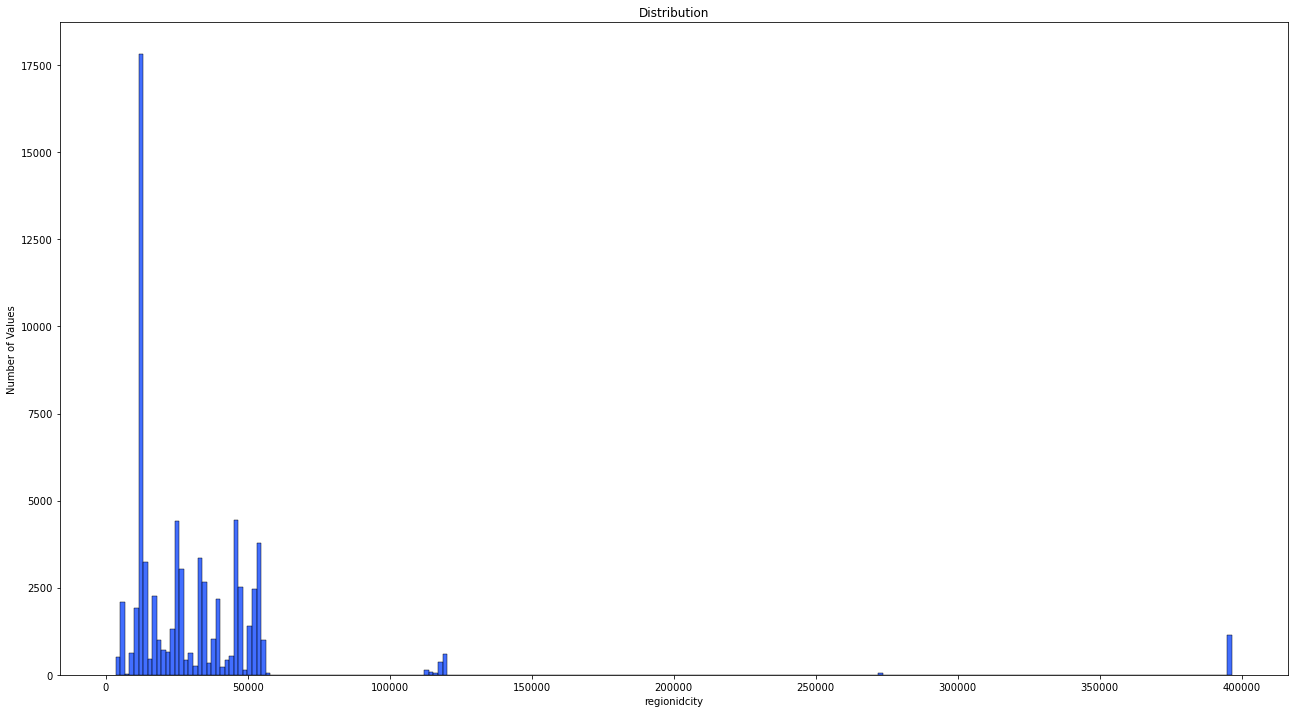

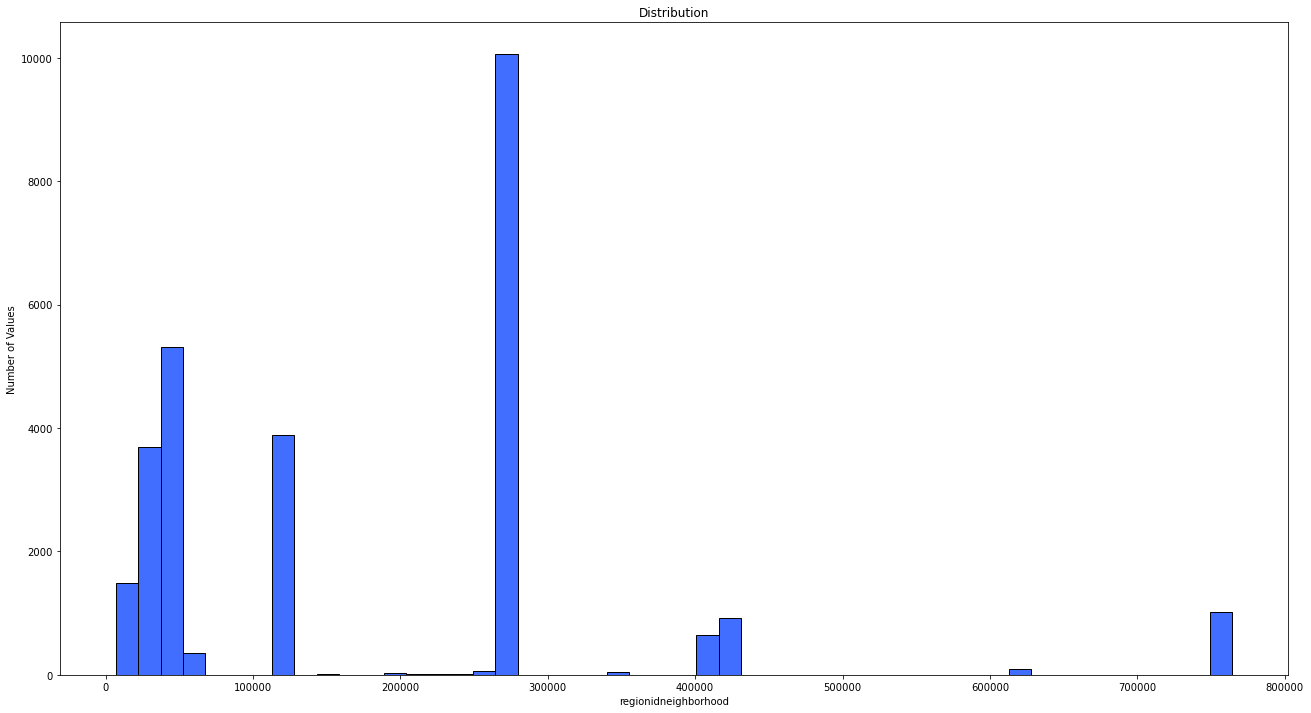

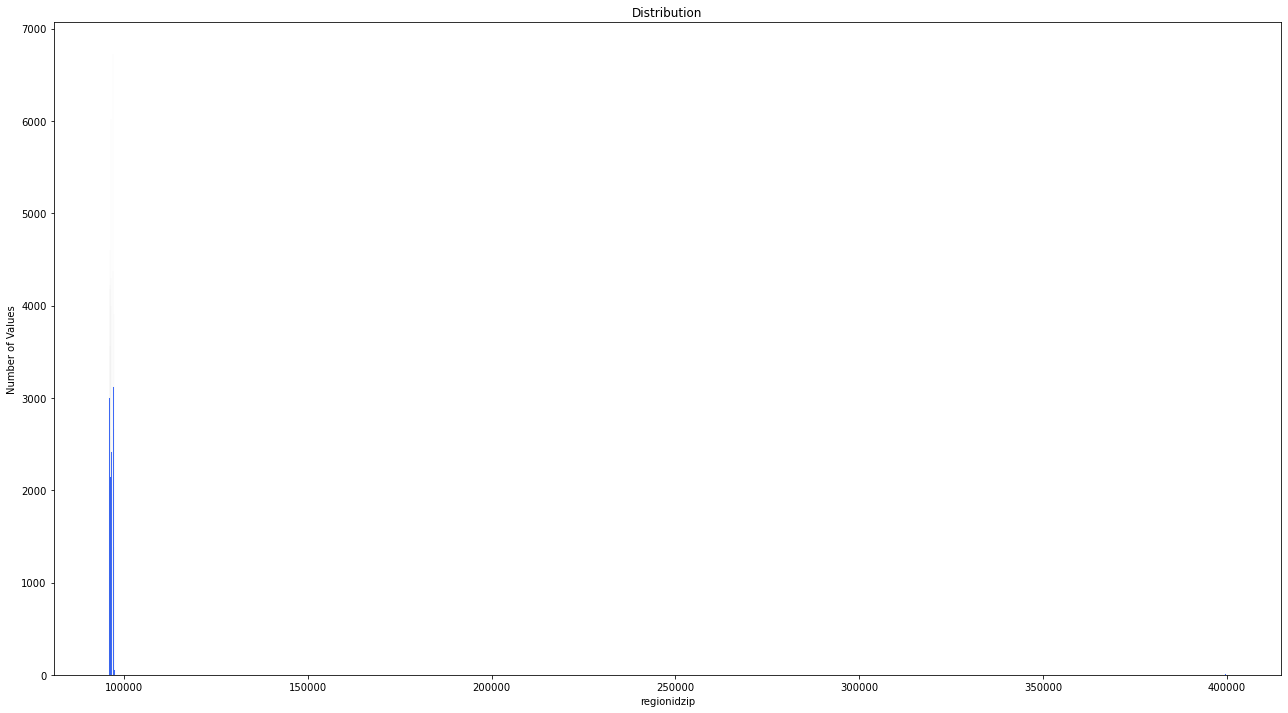

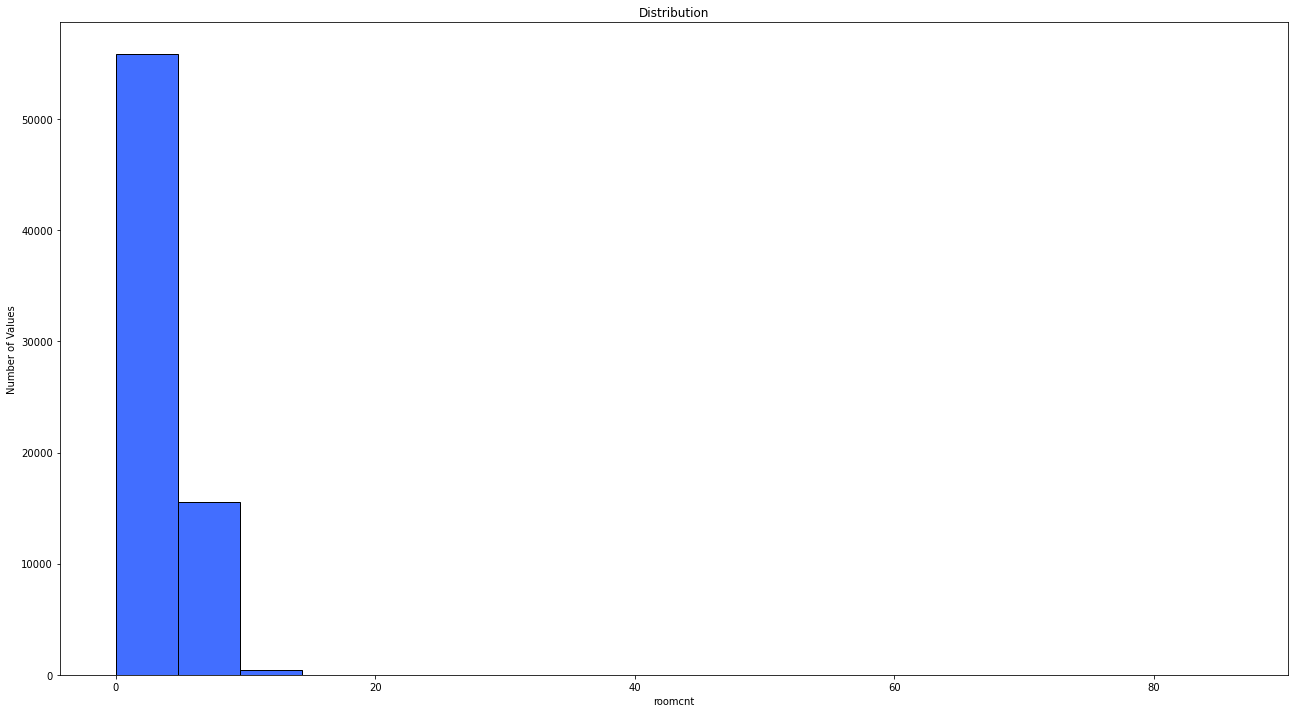

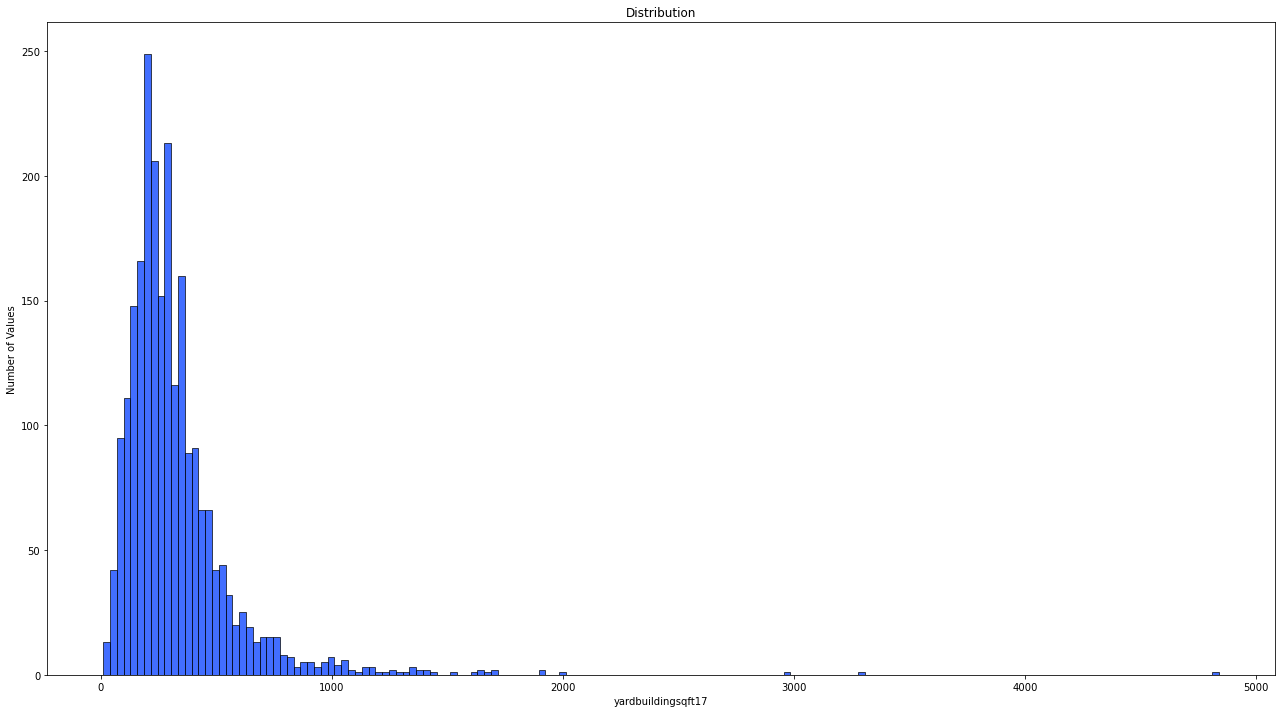

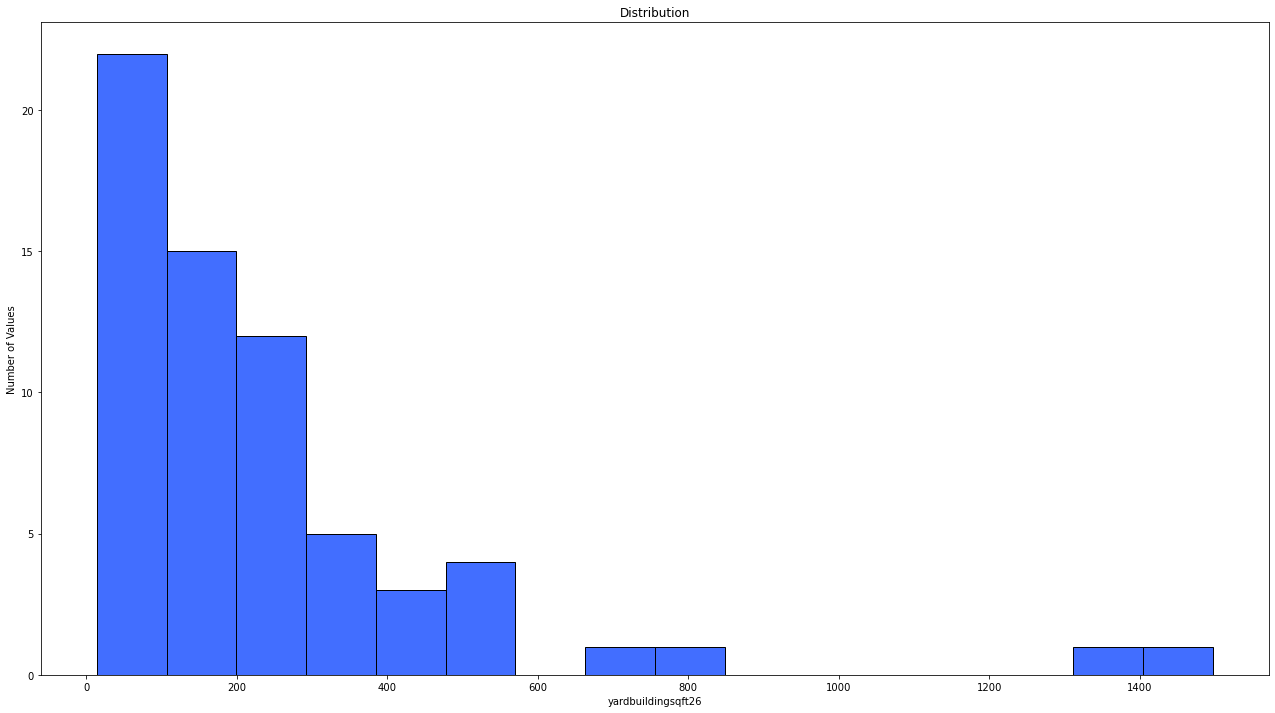

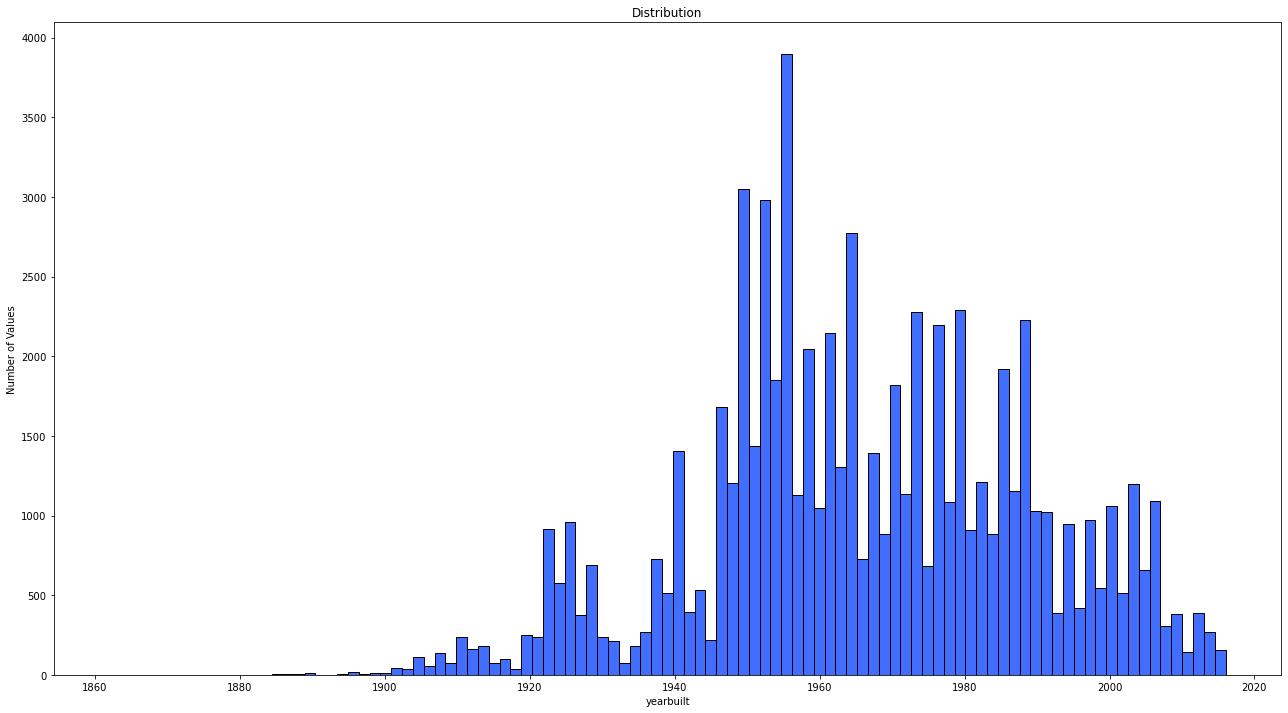

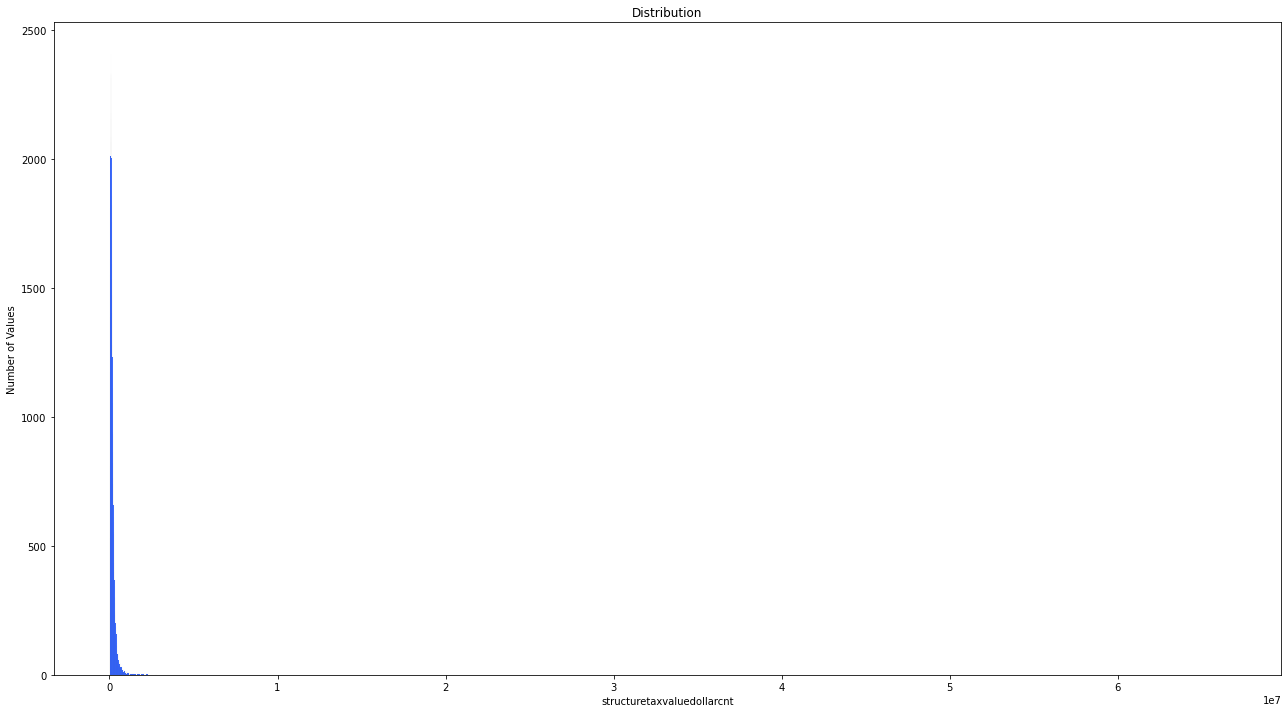

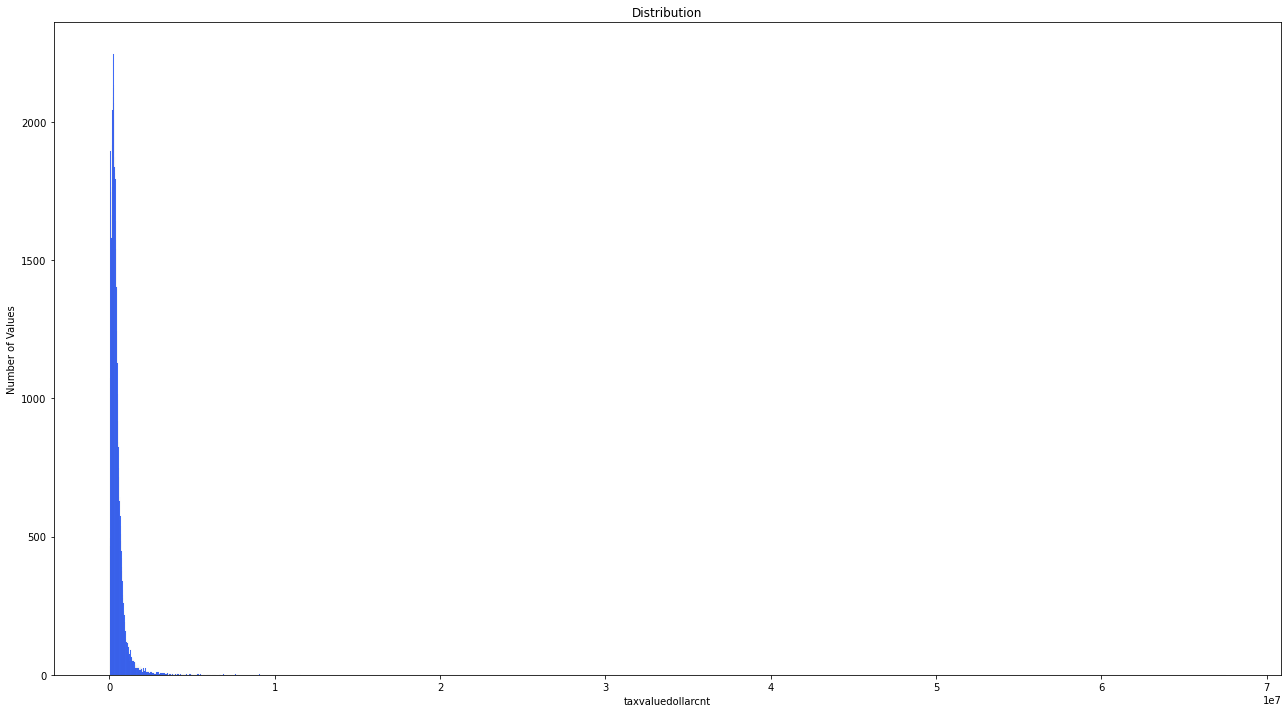

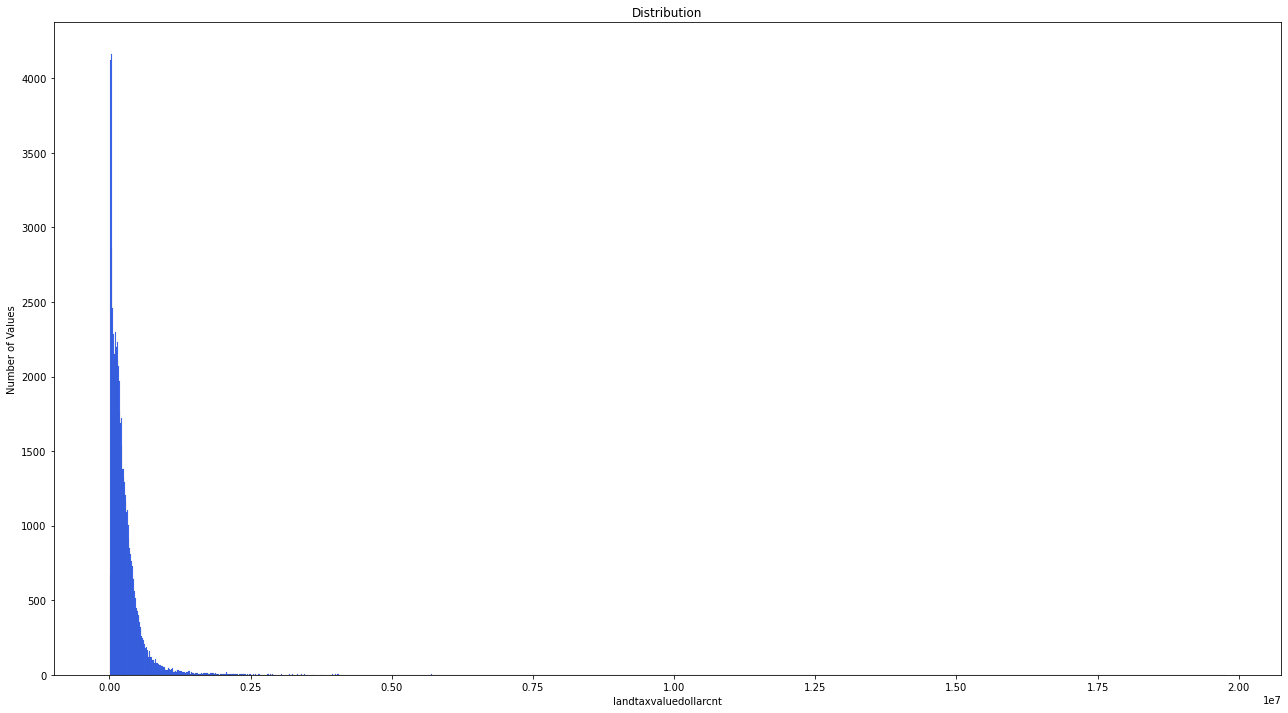

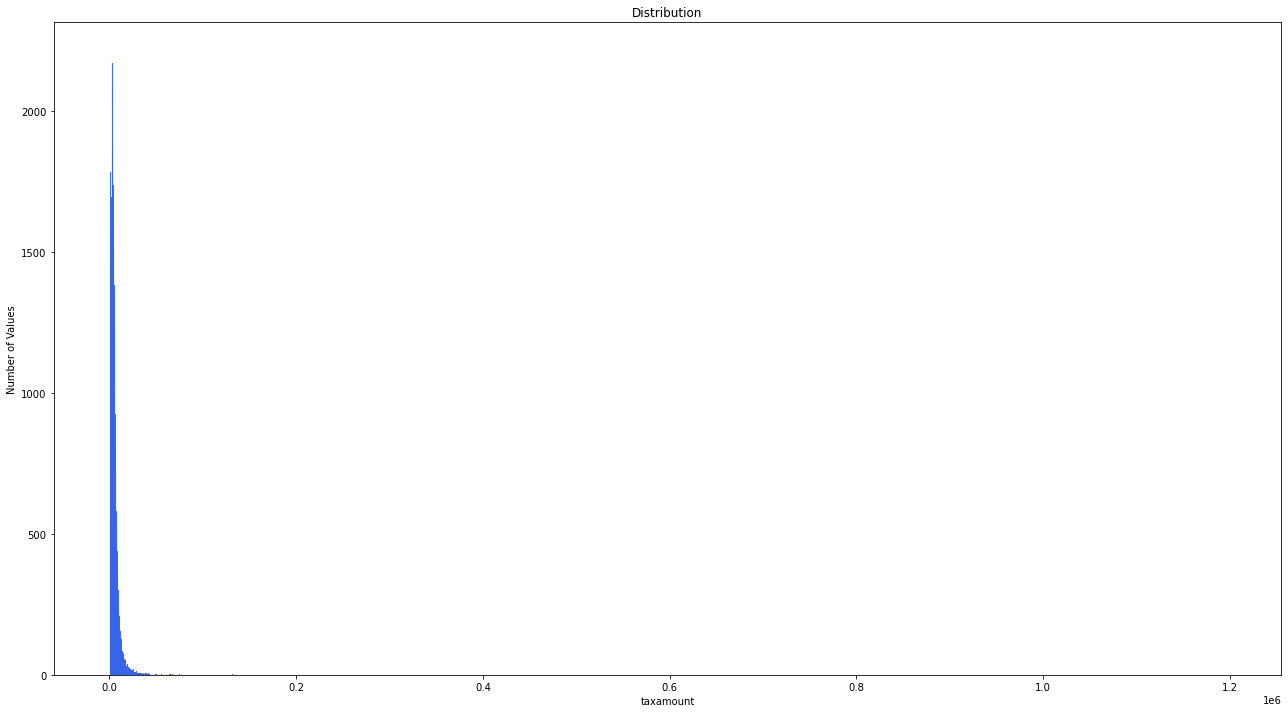

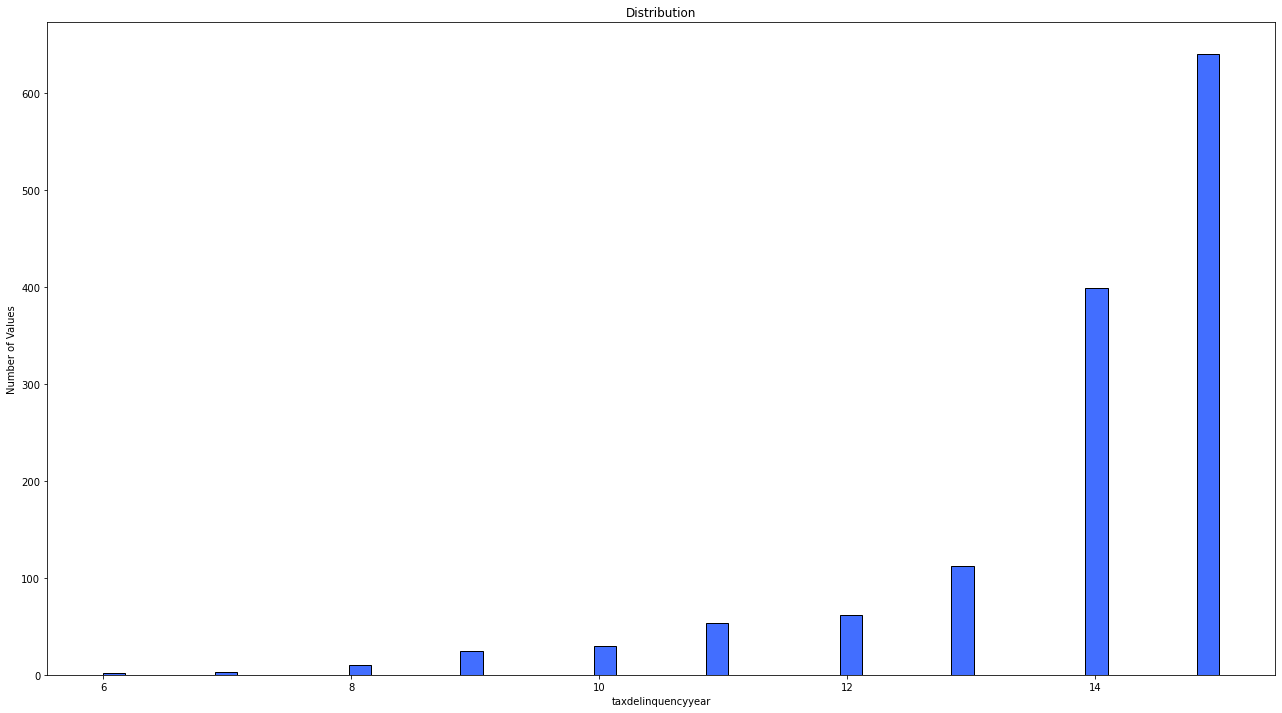

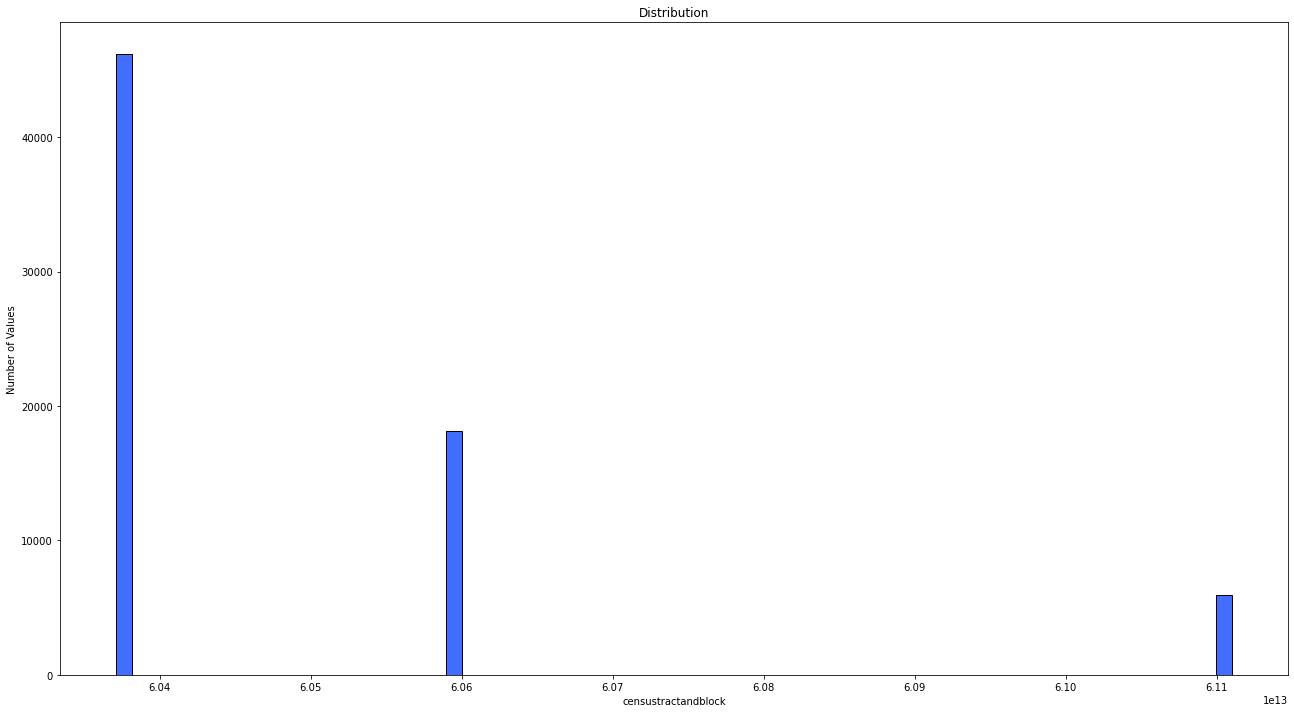

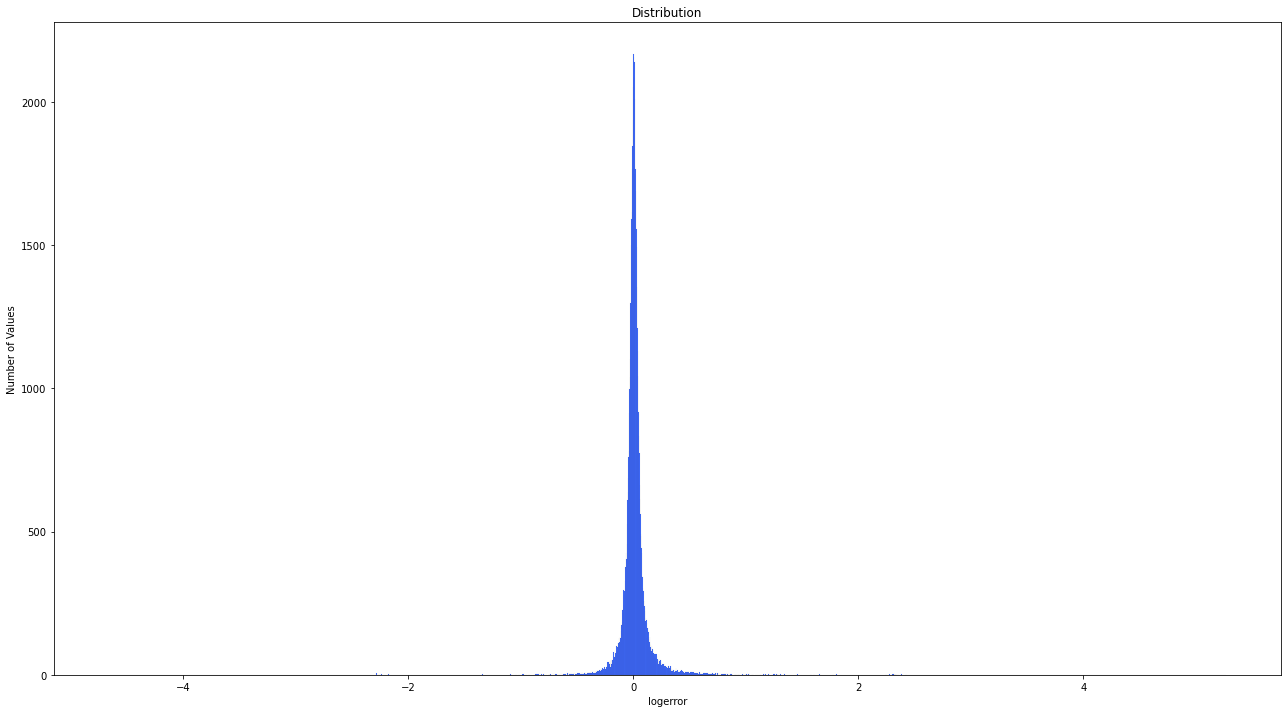

In [11]:
numeric_values_high_value_count(df)

<AxesSubplot:title={'center':'Value Counts'}, xlabel='typeconstructiondesc', ylabel='Number of Values'>

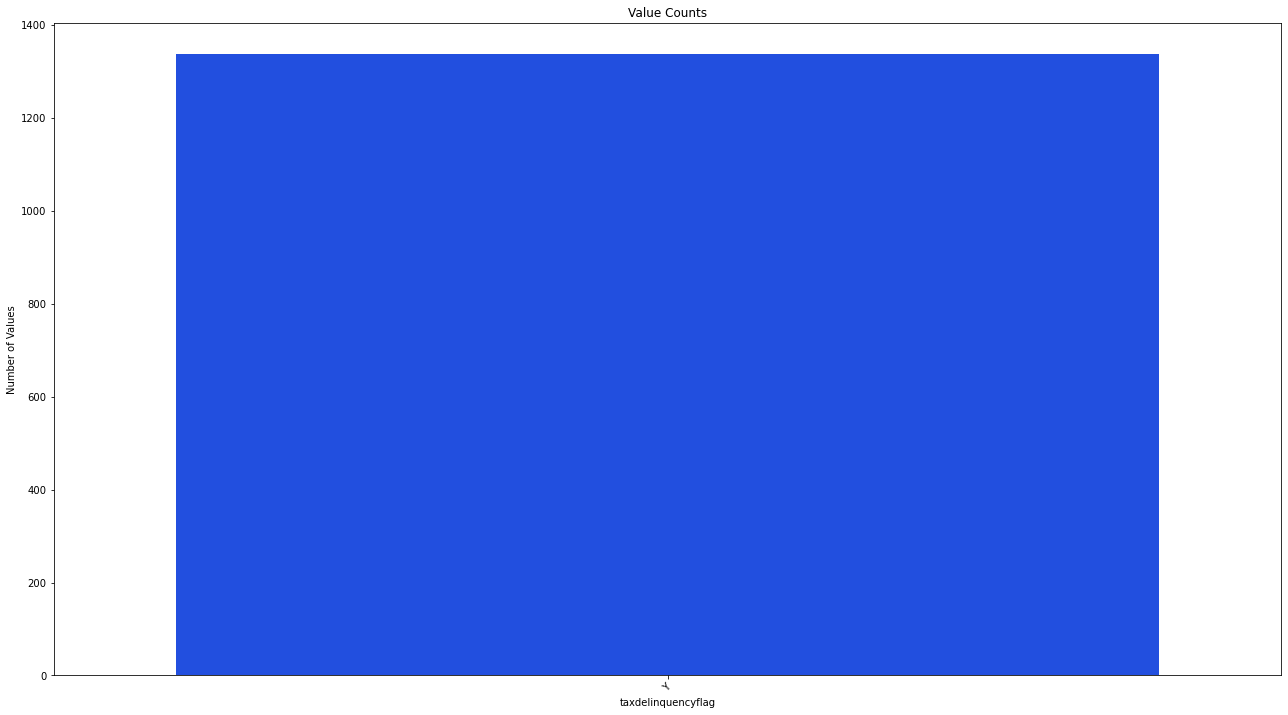

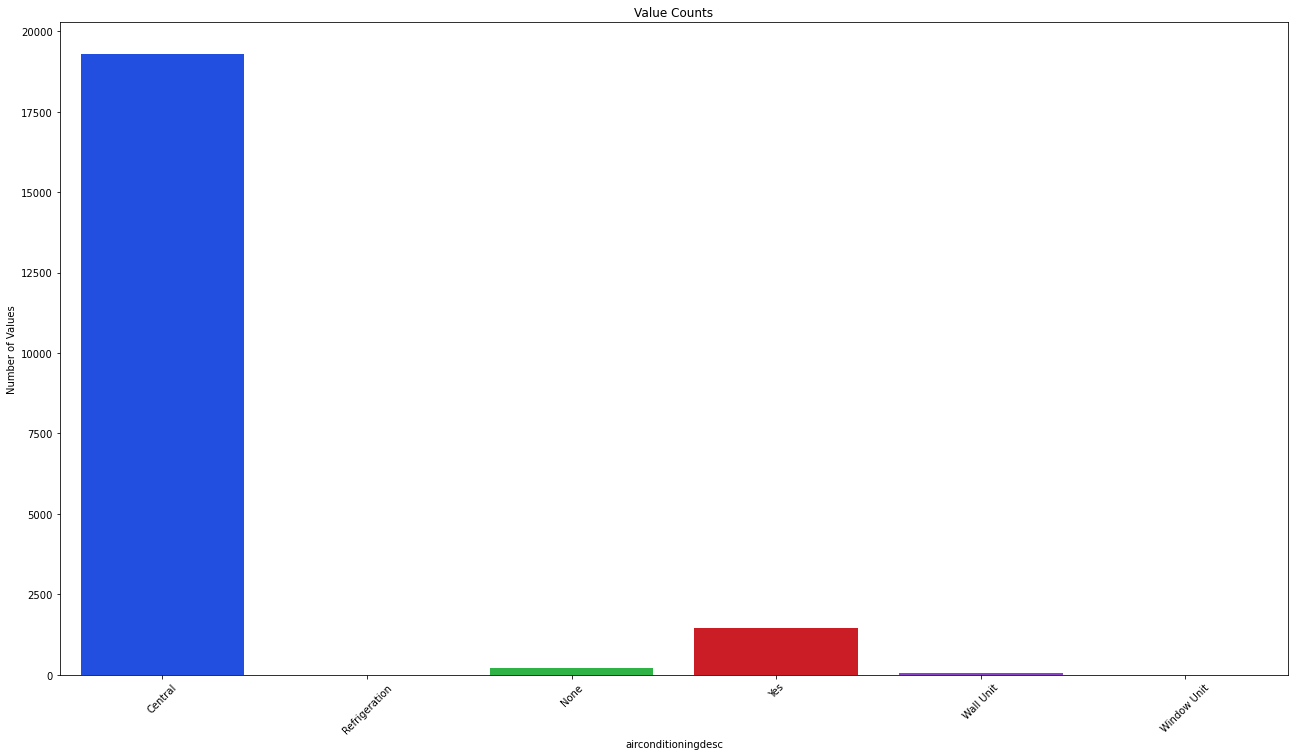

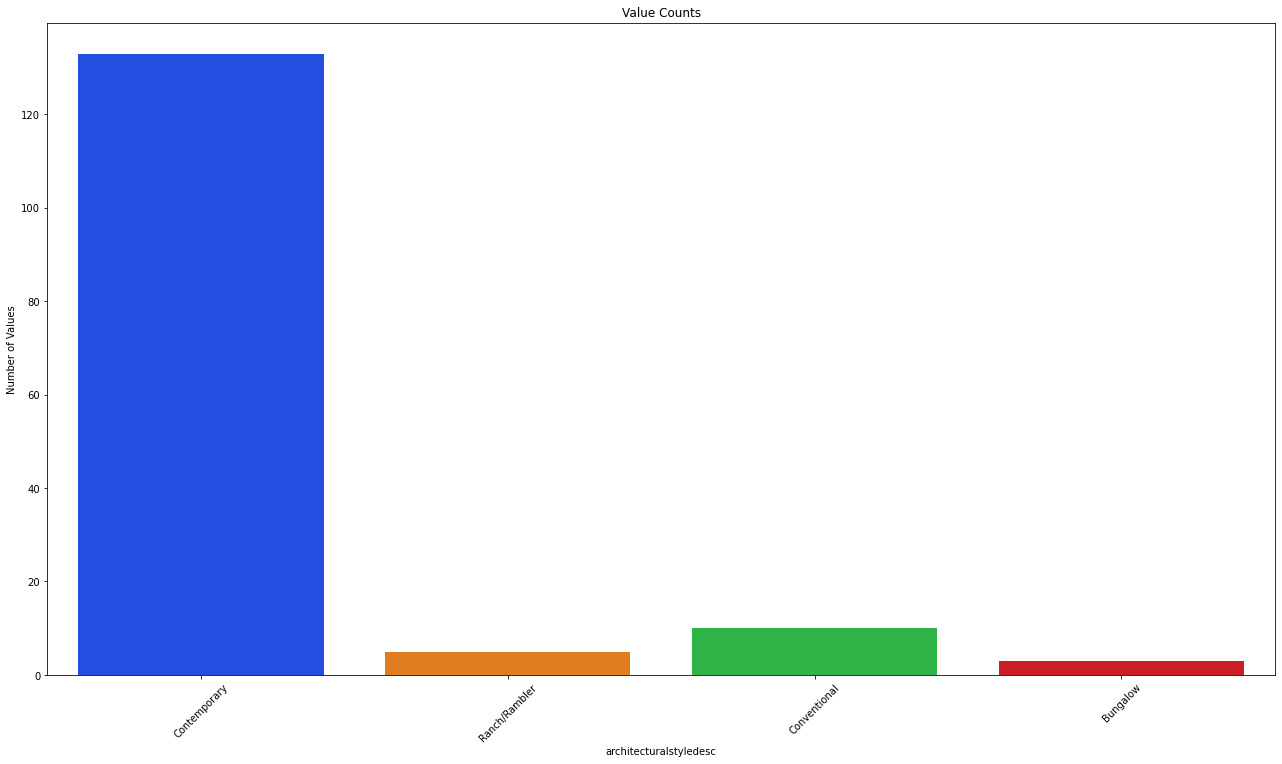

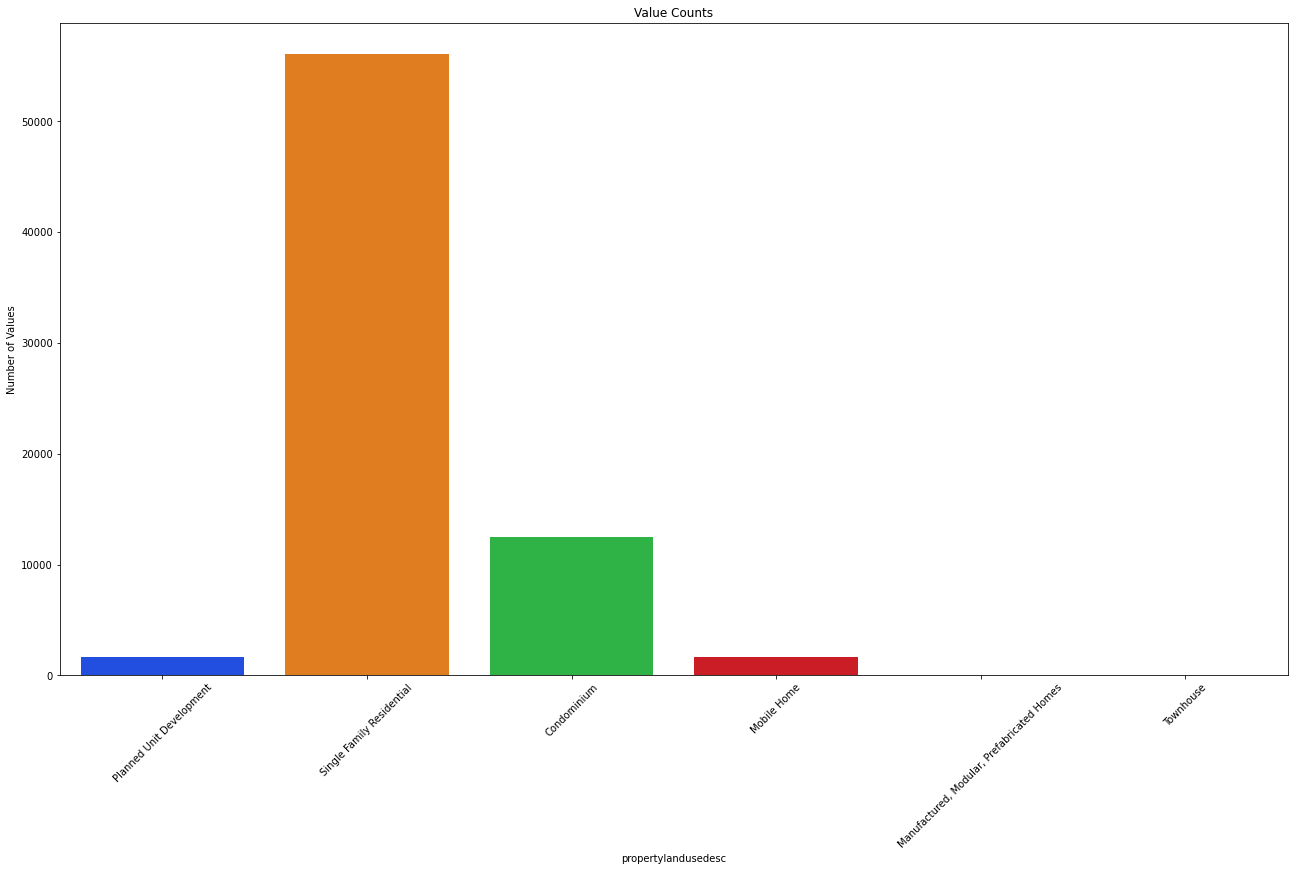

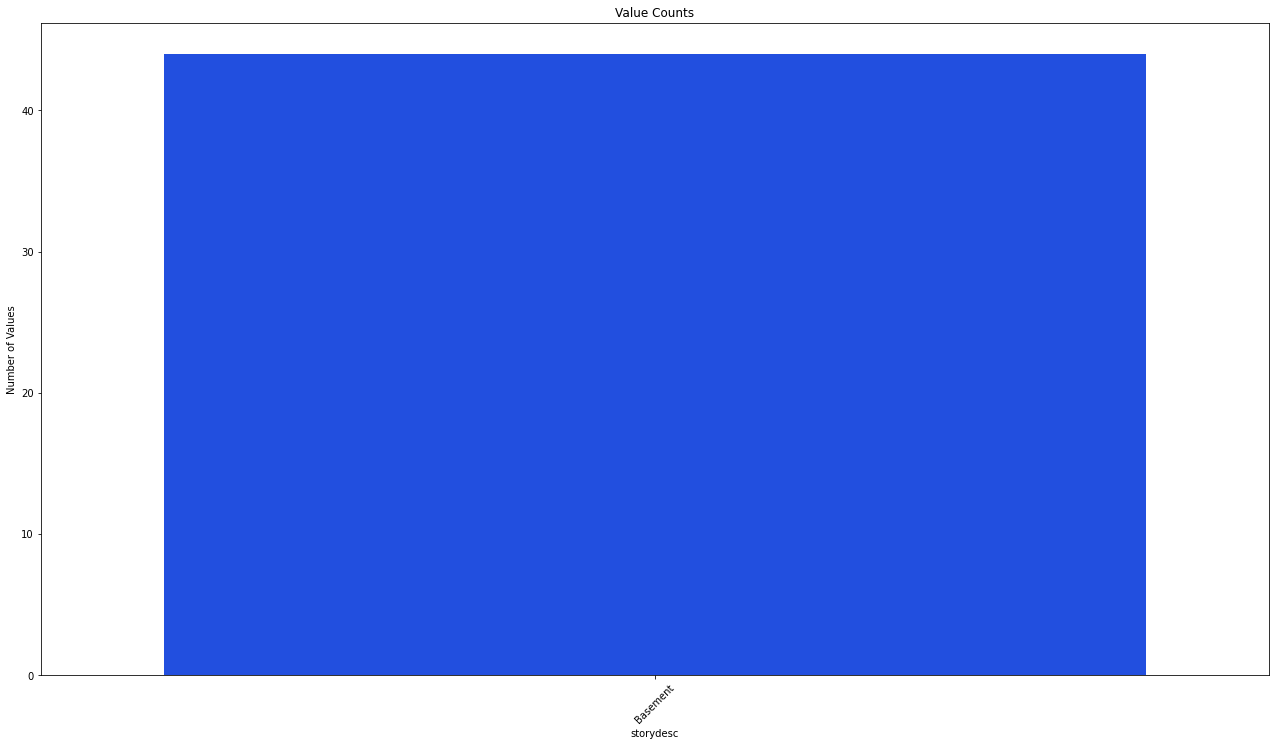

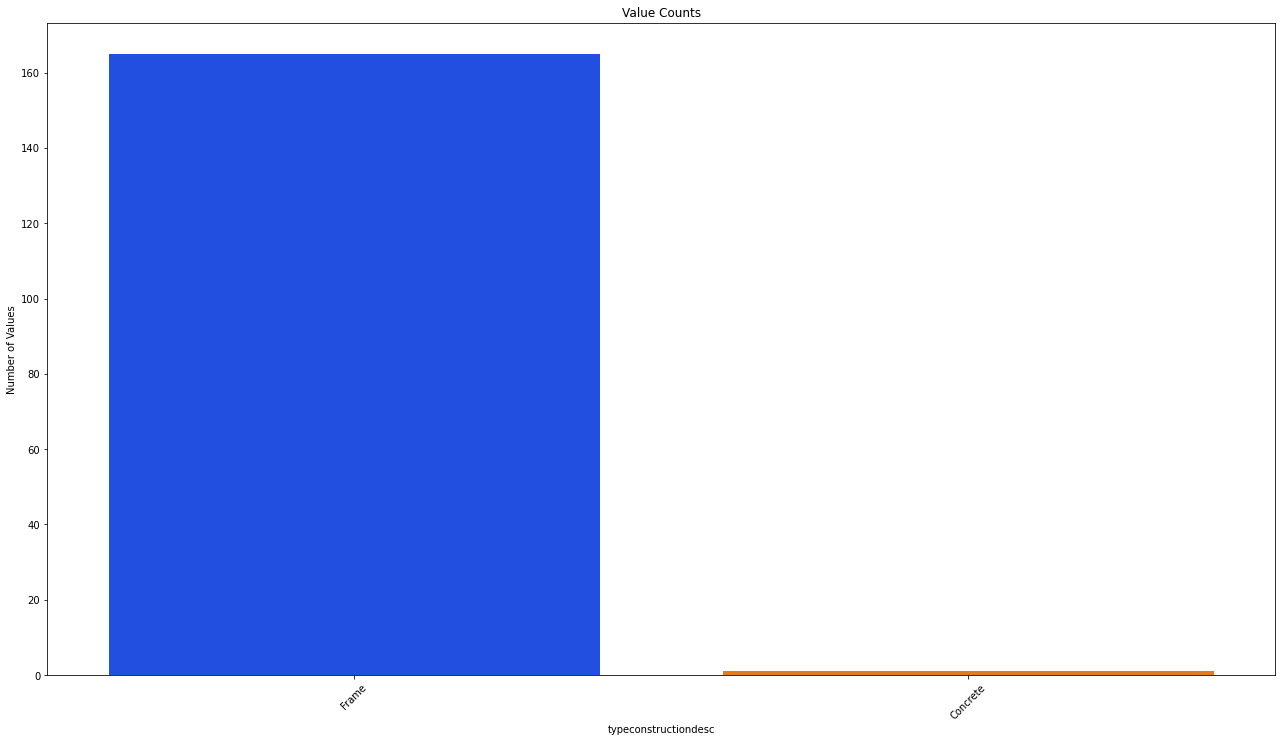

In [12]:
object_values_low_value_count(df)

In [6]:
for col in df.columns:
    if df[col].dtype == object and len(df[col].unique()) >= 10:
        print(col)

propertycountylandusecode
propertyzoningdesc
heatingorsystemdesc
transactiondate
last_trans_date


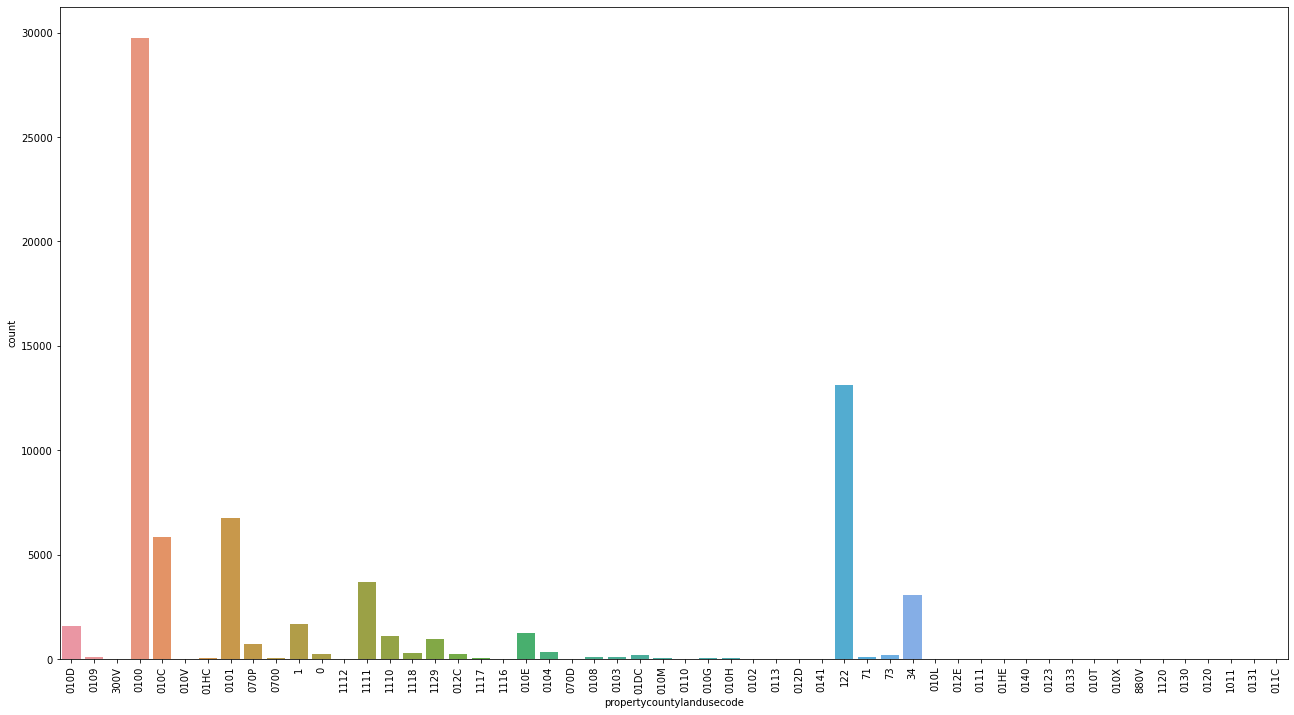

In [9]:
plt.figure(figsize=(22, 12))
landusecode = sns.countplot(x = df.propertycountylandusecode, data = df)
x_ticks = plt.xticks(rotation = 90)

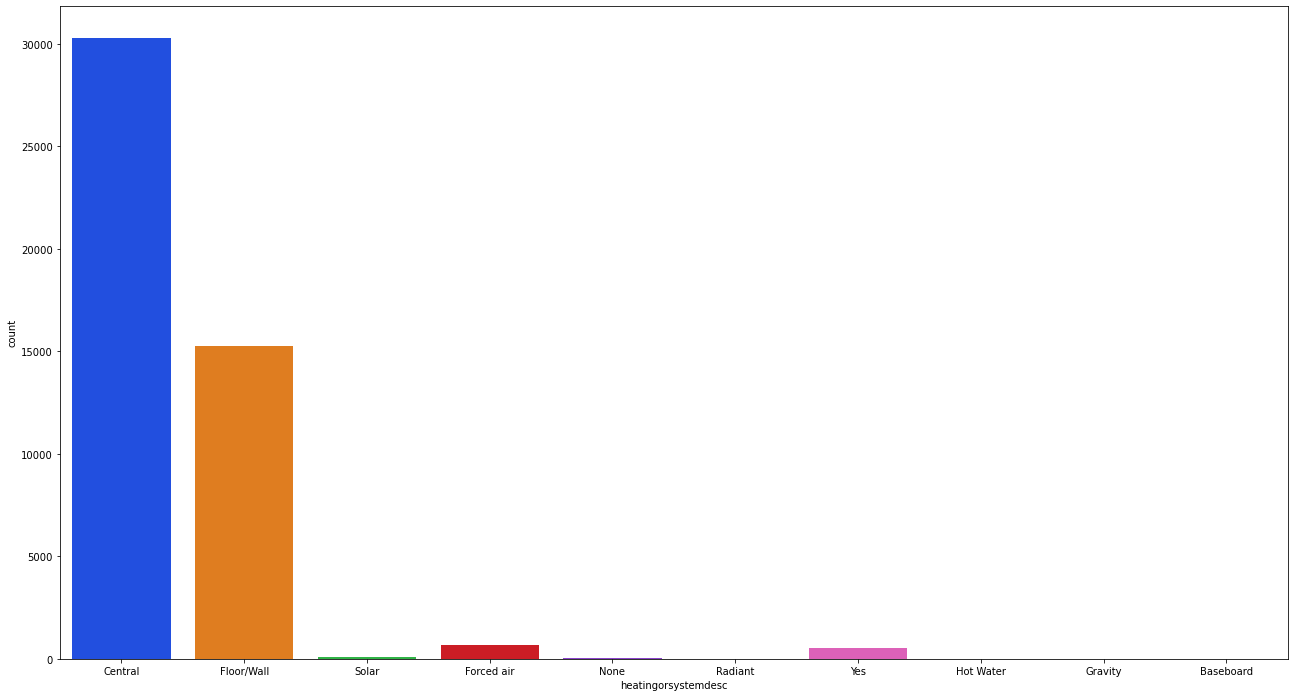

In [10]:
plt.figure(figsize=(22, 12))
heating = sns.countplot(x = df.heatingorsystemdesc, data = df)

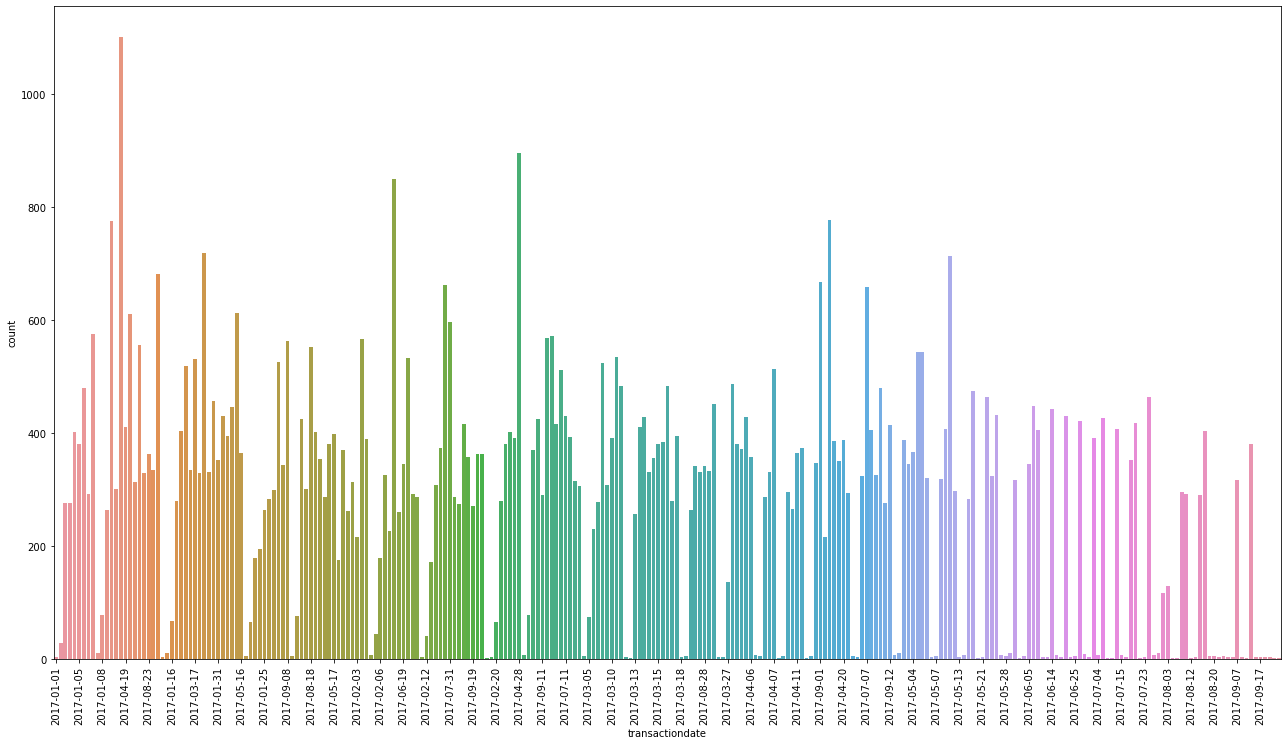

In [11]:
plt.figure(figsize=(22, 12))
transaction = sns.countplot(x = df.transactiondate, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = transaction.set_xticks(transaction.get_xticks()[::5])

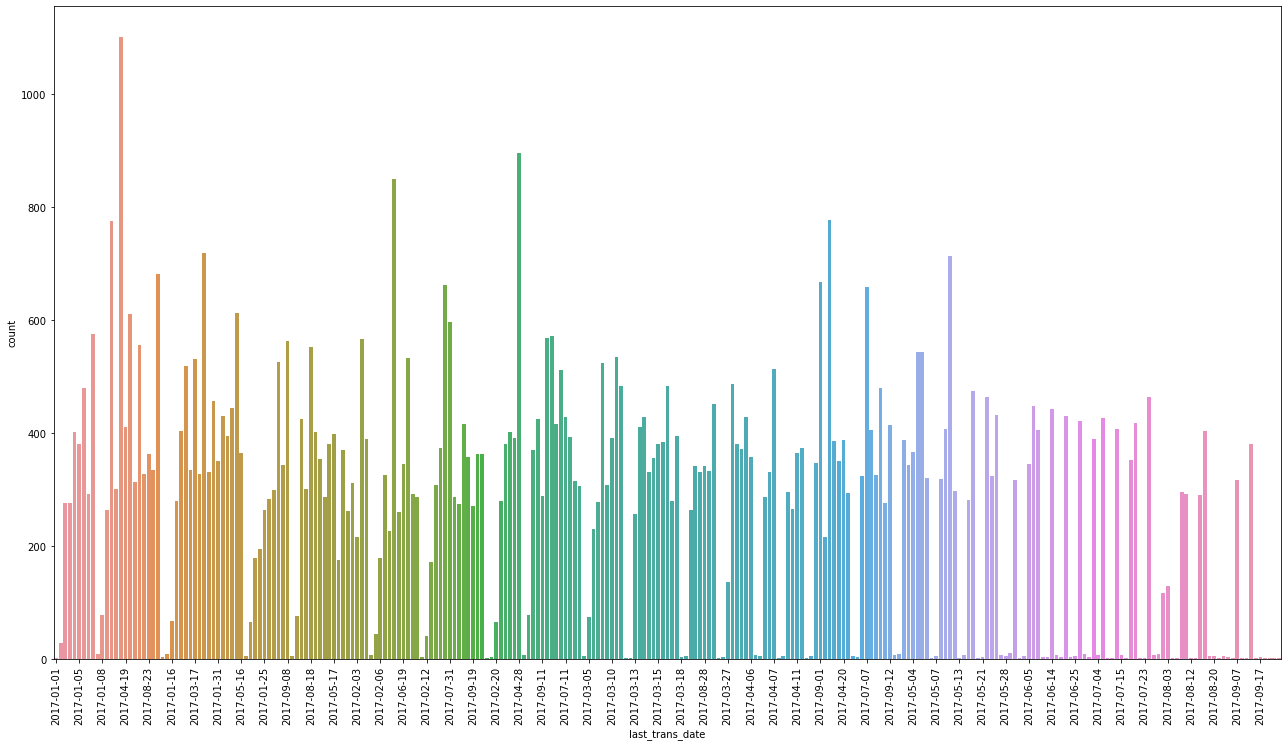

In [12]:
plt.figure(figsize=(22, 12))
last_transaction = sns.countplot(x = df.last_trans_date, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 90)
labels = last_transaction.set_xticks(last_transaction.get_xticks()[::5])

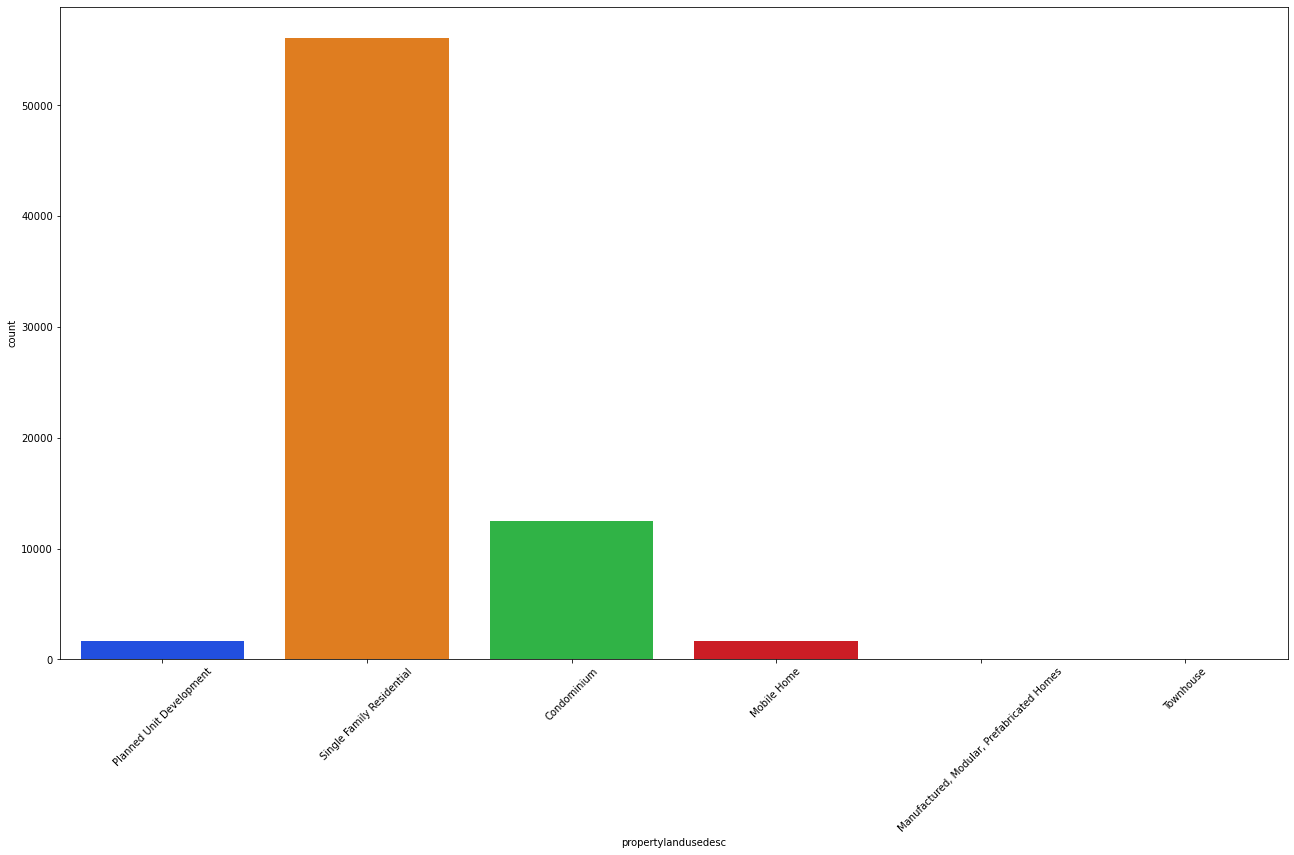

In [13]:
plt.figure(figsize=(22, 12))
land_use = sns.countplot(x = df.propertylandusedesc, data = df.sample(1000))
x_ticks = plt.xticks(rotation = 45)

## Prepare Data

In [4]:
df = prepare_data(df)

In [6]:
df.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
3,10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
10,20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
12,30,266.0,30,2.0,11524947,2.0,2.0,7.0,2.0,1090.0,...,357568.0,2016.0,124671.0,6165.36,6.037920e+13,Central,0.021853,2017-01-02,2017-01-02,Condominium
13,31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
14,33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69957 entries, 3 to 71904
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   index                         69957 non-null  int64  
 1   propertylandusetypeid         69957 non-null  float64
 2   id                            69957 non-null  int64  
 3   heatingorsystemtypeid         69957 non-null  float64
 4   parcelid                      69957 non-null  int64  
 5   bathroomcnt                   69957 non-null  float64
 6   bedroomcnt                    69957 non-null  float64
 7   buildingqualitytypeid         69957 non-null  float64
 8   calculatedbathnbr             69957 non-null  float64
 9   calculatedfinishedsquarefeet  69957 non-null  float64
 10  finishedsquarefeet12          69957 non-null  float64
 11  fips                          69957 non-null  float64
 12  fullbathcnt                   69957 non-null  float64
 13  l

In [8]:
df.describe()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
count,69957.000000,69957.000000,69957.000000,69957.000000,6.995700e+04,69957.000000,69957.000000,69957.000000,69957.000000,69957.000000,...,69957.000000,69957.000000,69957.000000,6.995700e+04,6.995700e+04,69957.000000,6.995700e+04,69957.000000,6.995700e+04,69957.000000
mean,38970.919765,262.073960,38970.919765,3.319353,1.319741e+07,2.254621,3.117143,6.288248,2.260467,1772.817745,...,1.633103,1.000743,1965.983947,1.772201e+05,4.404596e+05,2015.998971,2.633455e+05,5372.114817,6.048869e+13,0.016913
std,22371.976276,2.191955,22371.976276,2.810856,6.590401e+06,0.960319,0.997331,1.392869,0.952073,922.951517,...,2.966145,0.053996,22.729093,2.173833e+05,5.508348e+05,0.039640,3.863801e+05,6351.562847,2.071586e+11,0.170756
min,10.000000,261.000000,10.000000,1.000000,1.071174e+07,0.000000,0.000000,1.000000,1.000000,20.000000,...,0.000000,1.000000,1862.000000,5.000000e+00,9.000000e+00,2014.000000,4.000000e+00,13.490000,6.037101e+13,-4.655420
25%,19470.000000,261.000000,19470.000000,2.000000,1.153516e+07,2.000000,2.000000,6.000000,2.000000,1203.000000,...,0.000000,1.000000,1952.000000,7.984400e+04,1.915770e+05,2016.000000,7.838900e+04,2518.600000,6.037400e+13,-0.024284
50%,39097.000000,261.000000,39097.000000,2.000000,1.255946e+07,2.000000,3.000000,6.000000,2.000000,1551.000000,...,0.000000,1.000000,1964.000000,1.289440e+05,3.248790e+05,2016.000000,1.762330e+05,4044.470000,6.037574e+13,0.006736
75%,58166.000000,261.000000,58166.000000,2.000000,1.412515e+07,3.000000,4.000000,7.000000,3.000000,2091.000000,...,0.000000,1.000000,1983.000000,2.065120e+05,5.178840e+05,2016.000000,3.268410e+05,6236.870000,6.059042e+13,0.039340
max,77613.000000,275.000000,77613.000000,24.000000,1.696019e+08,20.000000,25.000000,12.000000,20.000000,26345.000000,...,86.000000,13.000000,2016.000000,1.087622e+07,3.016684e+07,2016.000000,1.976448e+07,342940.380000,6.111009e+13,5.262999


### Remove outliers

In [5]:
df = data_no_outliers(df)

In [6]:
df.head()

,index,propertylandusetypeid,id,heatingorsystemtypeid,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,logerror,transactiondate,last_trans_date,propertylandusedesc
3,10,269.0,10,2.0,11070347,4.0,4.0,1.0,4.0,3095.0,...,192544.0,2016.0,53784.0,2460.72,6.037920e+13,Central,0.005963,2017-01-02,2017-01-02,Planned Unit Development
10,20,261.0,20,2.0,11324547,2.0,4.0,8.0,2.0,3633.0,...,296425.0,2016.0,74104.0,6941.39,6.037920e+13,Central,0.042463,2017-01-02,2017-01-02,Single Family Residential
13,31,261.0,31,2.0,11544747,4.0,3.0,11.0,4.0,1620.0,...,847770.0,2016.0,508238.0,10244.94,6.037920e+13,Central,-0.019546,2017-01-02,2017-01-02,Single Family Residential
14,33,261.0,33,2.0,11585547,2.0,3.0,8.0,2.0,2077.0,...,646760.0,2016.0,436568.0,7924.68,6.037920e+13,Central,-0.040807,2017-01-02,2017-01-02,Single Family Residential
18,46,266.0,46,2.0,11780147,1.0,0.0,6.0,1.0,700.0,...,387288.0,2016.0,115979.0,4920.64,6.037920e+13,None,0.054203,2017-01-02,2017-01-02,Condominium


In [8]:
df.shape

(58900, 36)

### Train, validate, test split

In [9]:
train, validate, test = split_data(df)

## Exploration

In [34]:
continuous = ['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fullbathcnt',
 'lotsizesquarefeet',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

In [36]:
X_train = train[continuous]

In [30]:
y_train = train['logerror']

In [37]:
# Create model
kbest_3 = SelectKBest(f_regression, k=3)
#Fit the model
kbest_3.fit(X_train, y_train)
X_train.columns[kbest_3.get_support()]

Index(['fullbathcnt', 'yearbuilt', 'taxamount'], dtype='object')

In [40]:
rfe_3 = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe_3.fit(X_train, y_train)
X_train.columns[rfe_3.get_support()]

Index(['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt'], dtype='object')

## Does the logerror of a property differ by county?

### Value Counts

In [11]:
train.fips.value_counts()

6037.0    20750
6059.0     9317
6111.0     2917
Name: fips, dtype: int64

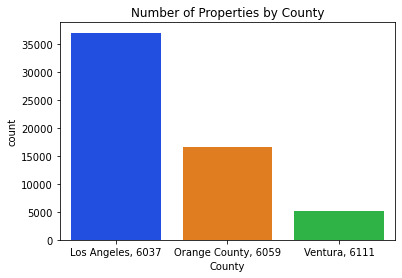

In [16]:
value_counts_by_county = sns.countplot(x = 'fips', data = df)
title = value_counts_by_county.set(title = "Number of Properties by County", xlabel = "County")
x_ticks = value_counts_by_county.set_xticklabels(['Los Angeles, 6037', 'Orange County, 6059', 'Ventura, 6111'])

### Average Logerror by County

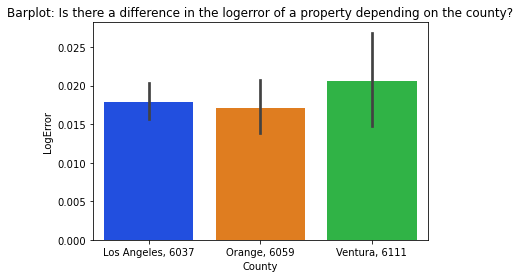

In [17]:
county_log_error = sns.barplot(data = train, y = 'logerror', x = 'fips')
title = plt.title("Barplot: Is there a difference in the logerror of a property depending on the county?")
xlabel = plt.xlabel("County")
ylabel = plt.ylabel("LogError")
xticks = county_log_error.set_xticklabels(["Los Angeles, 6037", "Orange, 6059", "Ventura, 6111"])

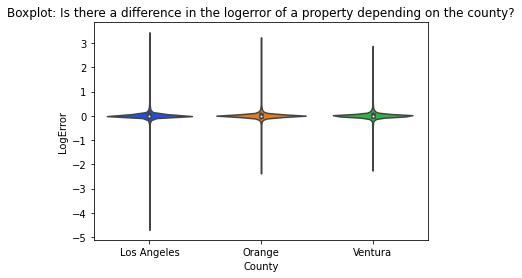

In [18]:
county_log_error = sns.violinplot(data = train, y = 'logerror', x = 'fips')
title = plt.title("Boxplot: Is there a difference in the logerror of a property depending on the county?")
xlabel = plt.xlabel("County")
ylabel = plt.ylabel("LogError")
xticks = county_log_error.set_xticklabels(["Los Angeles", "Orange", "Ventura"])

### Statistical Testing

For the following statistical tests, we set our alpha value to $0.05$. 

#### Leven's Test

$H_0:$ There is no difference in log error variance between Los Angeles and Orange County. 

$H_a:$ There is a significant difference in log error between Los Angeles and Orange County.

In [19]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6059.0').logerror,
)

LeveneResult(statistic=0.00023712544626568424, pvalue=0.987714060675207)

**Conclusion** 

Because or pvalue is high, we fail to reject the null hypothesis.

$H_0:$ There is no difference in log error variance between Ventura and Orange County. 

$H_a:$ There is a significant difference in log error between Ventura and Orange County.

In [20]:
stats.levene(
    train.query('fips == 6059.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=0.41558221947064194, pvalue=0.5191617922469245)

**Conclusion**

Because our pvalue is high, we fail to reject the null hypothesis.

$H_0:$ There is no difference in log error variance between Ventura and Los Angeles. 

$H_a:$ There is a significant difference in log error between Ventura and Los Angeles.

In [22]:
stats.levene(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
)

LeveneResult(statistic=0.4888687121100456, pvalue=0.48443925220679684)

**Conclusion**

Because our pvalue is high, we fail to reject the null hypothesis.

#### T test

$H_0$: There is no difference in log error for Orange and Ventura County.

$H_a$: There is a significant different in log error for Orange and Ventura County.

In [24]:
stats.ttest_ind(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.34026308161465996, pvalue=0.733660793998486)

$H_0$: There is no difference in log error for Los Angeles and Ventura County.

$H_a$: There is a significant different in log error for Los Angeles and Ventura County.

In [25]:
stats.ttest_ind(
    train.query('fips == 6037.0').logerror,
    train.query('fips == 6111.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=-0.7953150658352451, pvalue=0.4264382285359085)

$H_0$: There is no difference in log error for Orange and Los Angeles County.

$H_a$: There is a significant different in log error for Orange and Los Angeles County.

In [26]:
stats.ttest_ind(
    train.query('fips == 6111.0').logerror,
    train.query('fips == 6059.0').logerror,
    equal_var = True
)

Ttest_indResult(statistic=0.9458408632789287, pvalue=0.34424844293391843)

There is no significant difference in log error between any of the counties.

### 